In [172]:
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

%matplotlib inline

# Process functions

In [173]:
def processMarkovLen(init):
    temp = []
    zeros = 0
    for i, v in enumerate(init):
        if(v == 0):
            zeros = zeros+1
            v = 2
        if(i>1):
            if(v==1):
                temp.append(init[i-1])
    temp.append(v)
    
    final = list(np.ones(int(temp[0]+1+zeros))*temp[0])
    for i in range(len(temp)-1):
        final += list(np.linspace(int(temp[i]), int(temp[i+1]), int(temp[i+1]+1)))[1:]
    return np.asarray(final)

In [174]:
def processDataDSA(pathTXT):
    acceptance_pb = []
    acc_best_sol = []
    temp = []
    density = []
    markov_len = []
    best_y = []
    curr_y = []
    runtime = 0
    iteration_nbr = 0
    
    with open(pathTXT, "r") as file:
        dimension = file.readline().count('BEST x')
        best_xs = np.zeros((dimension, 0))
        curr_xs = np.zeros((dimension, 0))

        for line in file:
            if(line.startswith("Runtime")):
                runtime = float(re.sub("[^0-9^.]", "", line))
            elif(line.startswith("Nbr")):
                iteration_nbr = int(re.sub("[^0-9]", "", line))
            else:
                final = 7
                a = line.split("|")
                a = [i.strip() for i in a][:-1]
                if(float(a[5])!=0):
                    acceptance_pb.append(float(a[0]))
                    acc_best_sol.append(a[1])
                    temp.append(float(a[2]))
                    density.append(float(a[3]))
                    markov_len.append(float(a[4]))
                    best_y.append(float(a[5]))
                    if(float(a[6])>10e6):
                        curr_y.append(60.0)
                    else: 
                        curr_y.append(float(a[6]))

                    best_xs_temp = np.zeros((dimension, 1))
                    curr_xs_temp = np.zeros((dimension, 1))
                    for i in range(dimension):
                        index = i*2
                        best_xs_temp[i] = float(a[final+index+1])
                        curr_xs_temp[i] = float(a[final+index])
                    best_xs = np.concatenate((best_xs, best_xs_temp), axis = 1)
                    curr_xs = np.concatenate((curr_xs, curr_xs_temp), axis = 1)
                
    acceptance_pb = np.asarray(acceptance_pb)
    acc_best_sol = np.asarray(acc_best_sol)
    temp = np.asarray(temp)
    best_y = np.asarray(best_y)
    curr_y = np.asarray(curr_y)
    
    density = np.asarray(density)
    markov_len = processMarkovLen(markov_len)[:len(temp)]
    
    
    return acceptance_pb, acc_best_sol, temp, density, markov_len, best_y, curr_y, best_xs, curr_xs, runtime, iteration_nbr

In [274]:
def drawPlotDSA(plotAll, best_y, curr_y, temp, acceptance_pb, acc_best_sol, density, markov_len, prob_factor, density_factor):
    set_matplotlib_formats('retina')

    x = np.arange(len(best_y))
    string = str(prob_factor)
    string2 = str(density_factor)
        
    line1, = plt.plot(x, best_y, color='g')
    if(plotAll):
        line2, = plt.plot(x, temp, color='orange', linewidth=3)
        #line3, = plt.plot(x, markov_len, color='grey')
        line5, = plt.plot(x, density*density_factor, color='k', linestyle='--')
        plt.scatter(x, acceptance_pb*prob_factor, s=10, marker='x', label='Acceptance proba x'+string, color='grey', alpha=0.5)
        line2.set_label('Temperature')
        #line3.set_label('Actual MarkovChains Length')
        line5.set_label('CG Density x'+string2)
        
    plt.scatter(x, curr_y, s=3, marker=">", label='Current Solution', color='blue')


    line1.set_label('Best Solution')

    fig = plt.gcf()
    fig.set_size_inches(12,6)
    

    ax2 = plt.gca()

    ax2.tick_params(axis='x', which='major', labelsize=14)
    ax2.tick_params(axis='y', which='major', labelsize=13)
    plt.yticks(rotation=90)

    plt.title('BoxPlot of both distributions', size=14)
    plt.xlabel('Number of iterations', size=14)
    plt.ylabel('Temperature / CGDensity / Proba', size=14)


    
    plt.legend(prop={'size': 14})
    #plt.yscale('log')
    plt.savefig('/Users/leobouraux/Desktop/foo1.png', format='png', dpi=333)

    plt.show()

# Plotting behavior of improvement to understand parameters

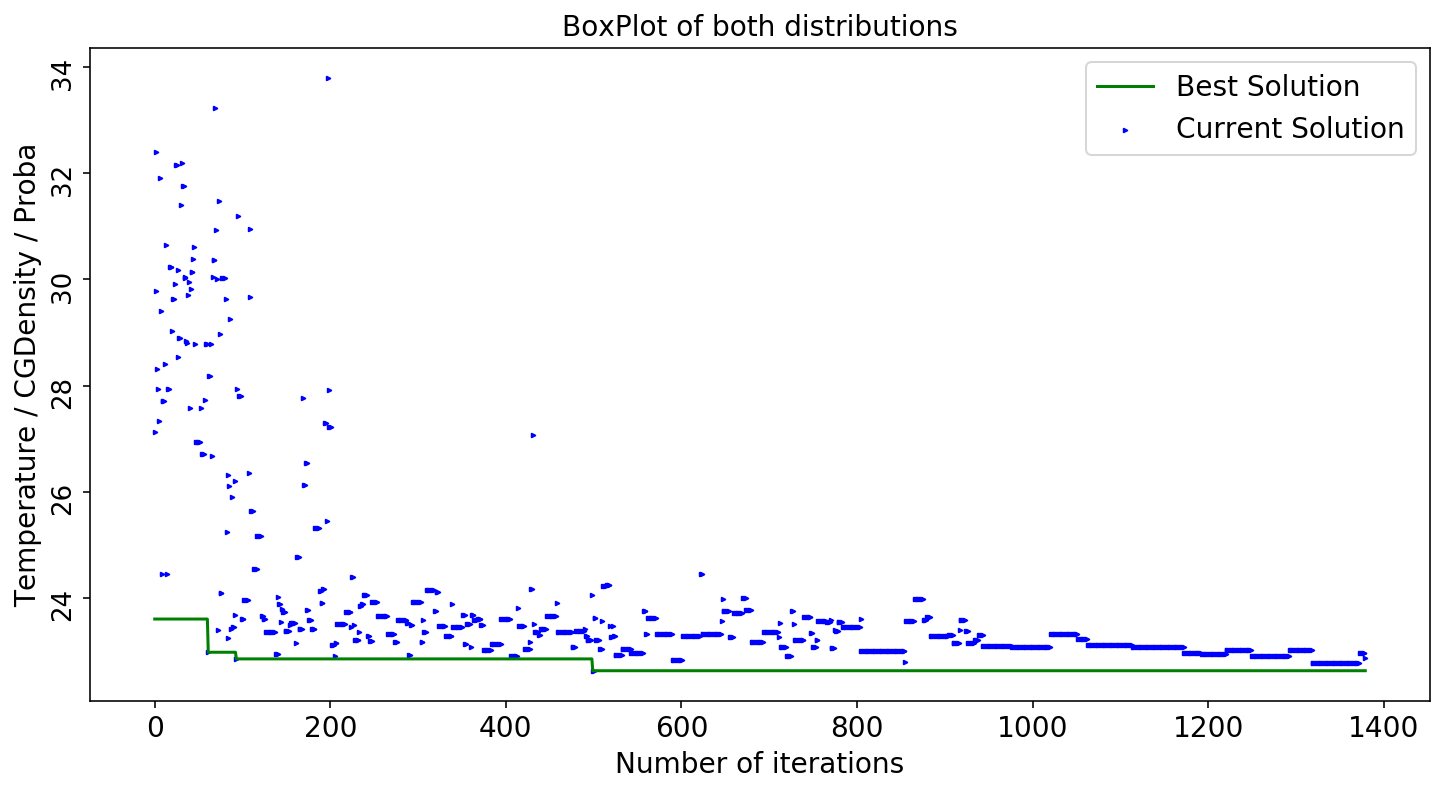

In [275]:
path = "../../../../GraphsSimu/data_to_visualize/density-217/DSA_results_xDiJTm1yP.txt"
acceptance_pb, acc_best_sol, temp, density, markov_len, best_y, curr_y, best_xs, curr_xs, runtime, iteration_nbr = processDataDSA(path)

density = np.append(np.ones(60)*density[60], density[60:])
drawPlotDSA(False, best_y, curr_y, temp, acceptance_pb, acc_best_sol, density, markov_len, prob_factor=5, density_factor=1)







# Plot the function 

All current solution greater than 30 are now equal to 30, we want to eliminate them !

In [163]:
import pandas as pd

def processData(pathTXT):
    a = []
    tab = []
    i = 0
    with open(pathTXT, "r") as file:
        for line in file:
            if(line.startswith("Runtime")):
                runtime = float(re.sub("[^0-9^.]", "", line))
            elif(line.startswith("Nbr")):
                iteration_nbr = int(re.sub("[^0-9]", "", line))
            else:
                a = line.split("|")[5:]
                a = [i.strip() for i in a][:-1]
                if(i!=0):
                    a = [float(i) for i in a]
                tab.append(a)
            i+=1
            
    titles = tab[0] 
    #print(titles)
    dtf = pd.DataFrame(data=tab[1:],columns=titles)
    
    isNotInit = dtf['BEST y']!=0.0
    dtf_all = dtf[isNotInit]
    
    aa = np.array(dtf_all['CURR y'].values.tolist())
    dtf_all['CURR y'] = [v if v < 30 else 30 for v in aa]


    col_to_del = [titles[0]]+titles[3::2]
    afterdrop_cur = dtf_all.drop(col_to_del, axis = 1)
    col_to_del = [titles[1]]+titles[2::2]
    afterdrop_bes = dtf_all.drop(col_to_del, axis = 1)
    
    
    return dtf_all, afterdrop_cur, afterdrop_bes

In [206]:
data, data_cur, data_best = processData('../simulations/OwnLejjl0_DSA_results.txt')
data

/Users/leobouraux/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


BEST y     CURR y    CURR x    BEST x   CURR x2   BEST x2   CURR x3  \
35    23.947455  30.000000  4.525627  4.003029  0.342209 -0.435343 -0.975437   
36    23.947455  24.534870  4.760857  4.003029 -0.294704 -0.435343 -1.421620   
37    23.947455  24.993427  4.124453  4.003029 -0.888305 -0.435343 -1.893668   
38    23.947455  25.272534  4.529404  4.003029  0.728384 -0.435343 -1.131322   
39    23.947455  30.000000  4.309831  4.003029 -0.954555 -0.435343 -1.772384   
40    23.947455  24.767049  4.761987  4.003029  1.871923 -0.435343 -0.702718   
41    23.947455  25.846903  4.046191  4.003029 -0.167014 -0.435343 -1.460707   
42    23.947455  24.474662  2.776869  4.003029  0.252214 -0.435343 -1.754602   
43    23.947455  24.239877  5.316277  4.003029 -0.447015 -0.435343 -0.794363   
44    23.947455  24.064497  3.398282  4.003029  1.497768 -0.435343 -2.459319   
45    23.947455  30.000000  2.110652  4.003029 -0.611003 -0.435343 -0.356549   
46    23.947455  25.217161  5.623681  4.003029  1.913809 -0.435343 -2.882837   
47    23.947455  24.473368  4.217103  4.003029  1.776023 -0.435343 -2.521344   
48    23.947455  25.130846  3.660843  4.003029 -0.710371 -0.435343 -0.555902   
49    23.947455  30.000000  4.358919  4.003029 -0.392430 -0.435343 -2.634917   
50    23.947455  29.141529  5.302944  4.003029  1.005566 -0.435343 -0.968455   
51    23.947455  29.141529  5.302944  4.003029  1.005566 -0.435343 -0.968455   
52    23.947455  24.902570  4.910249  4.003029 -0.768438 -0.435343 -2.240851   
53    23.947455  24.902570  4.910249  4.003029 -0.768438 -0.435343 -2.240851   
54    23.947455  26.187799  5.662208  4.003029  1.384081 -0.435343 -0.662913   
55    23.947455  24.501128  5.752002  4.003029  0.167338 -0.435343 -0.578047   
56    23.947455  25.141262  2.724415  4.003029  1.925431 -0.435343 -1.574988   
57    23.947455  28.637380  5.879853  4.003029  1.681827 -0.435343 -2.446616   
58    23.947455  24.502738  3.017741  4.003029  0.127510 -0.435343 -1.963526   
59    23.947455  24.748548  3.865741  4.003029 -1.511790 -0.435343 -0.451998   
60    23.947455  24.944536  3.677272  4.003029  0.787047 -0.435343 -1.705734   
61    23.947455  24.450094  5.246988  4.003029  0.866664 -0.435343 -0.470059   
62    23.947455  24.450094  5.246988  4.003029  0.866664 -0.435343 -0.470059   
63    23.947455  24.450094  5.246988  4.003029  0.866664 -0.435343 -0.470059   
64    23.947455  24.395223  5.672728  4.003029 -1.571885 -0.435343 -2.049372   
...         ...        ...       ...       ...       ...       ...       ...   
1201  23.619419  25.209515  4.878555  4.220779 -1.766164  0.859727 -0.096155   
1202  23.619419  25.209515  4.878555  4.220779 -1.766164  0.859727 -0.096155   
1203  23.619419  24.664338  2.428203  4.220779 -1.926807  0.859727 -1.913736   
1204  23.619419  26.217000  3.703643  4.220779  1.058767  0.859727 -0.137300   
1205  23.619419  28.051036  3.515944  4.220779  1.799637  0.859727 -0.762120   
1206  23.619419  23.990069  5.681781  4.220779  1.316558  0.859727 -1.797950   
1207  23.619419  24.469103  4.204193  4.220779  0.443548  0.859727 -2.900401   
1208  23.619419  25.438788  2.400066  4.220779 -1.640884  0.859727 -0.002430   
1209  23.619419  23.943729  5.217990  4.220779 -1.875649  0.859727 -2.065742   
1210  23.619419  23.943729  5.217990  4.220779 -1.875649  0.859727 -2.065742   
1211  23.619419  24.574247  5.178862  4.220779 -1.381937  0.859727 -1.172983   
1212  23.619419  24.732228  3.444634  4.220779  1.444562  0.859727 -2.996970   
1213  23.619419  26.967278  4.980442  4.220779  0.092957  0.859727 -1.928159   
1214  23.619419  26.967278  4.980442  4.220779  0.092957  0.859727 -1.928159   
1215  23.619419  24.226836  4.725812  4.220779 -0.707885  0.859727 -1.457392   
1216  23.619419  24.454461  3.797103  4.220779 -1.289029  0.859727 -1.861269   
1217  23.619419  23.756628  5.003768  4.220779 -1.349045  0.859727 -0.682024   
1218  23.619419  24.885706  3.793963  4.220779 -0.326316  0.859727 -2.780122   
1219  23.

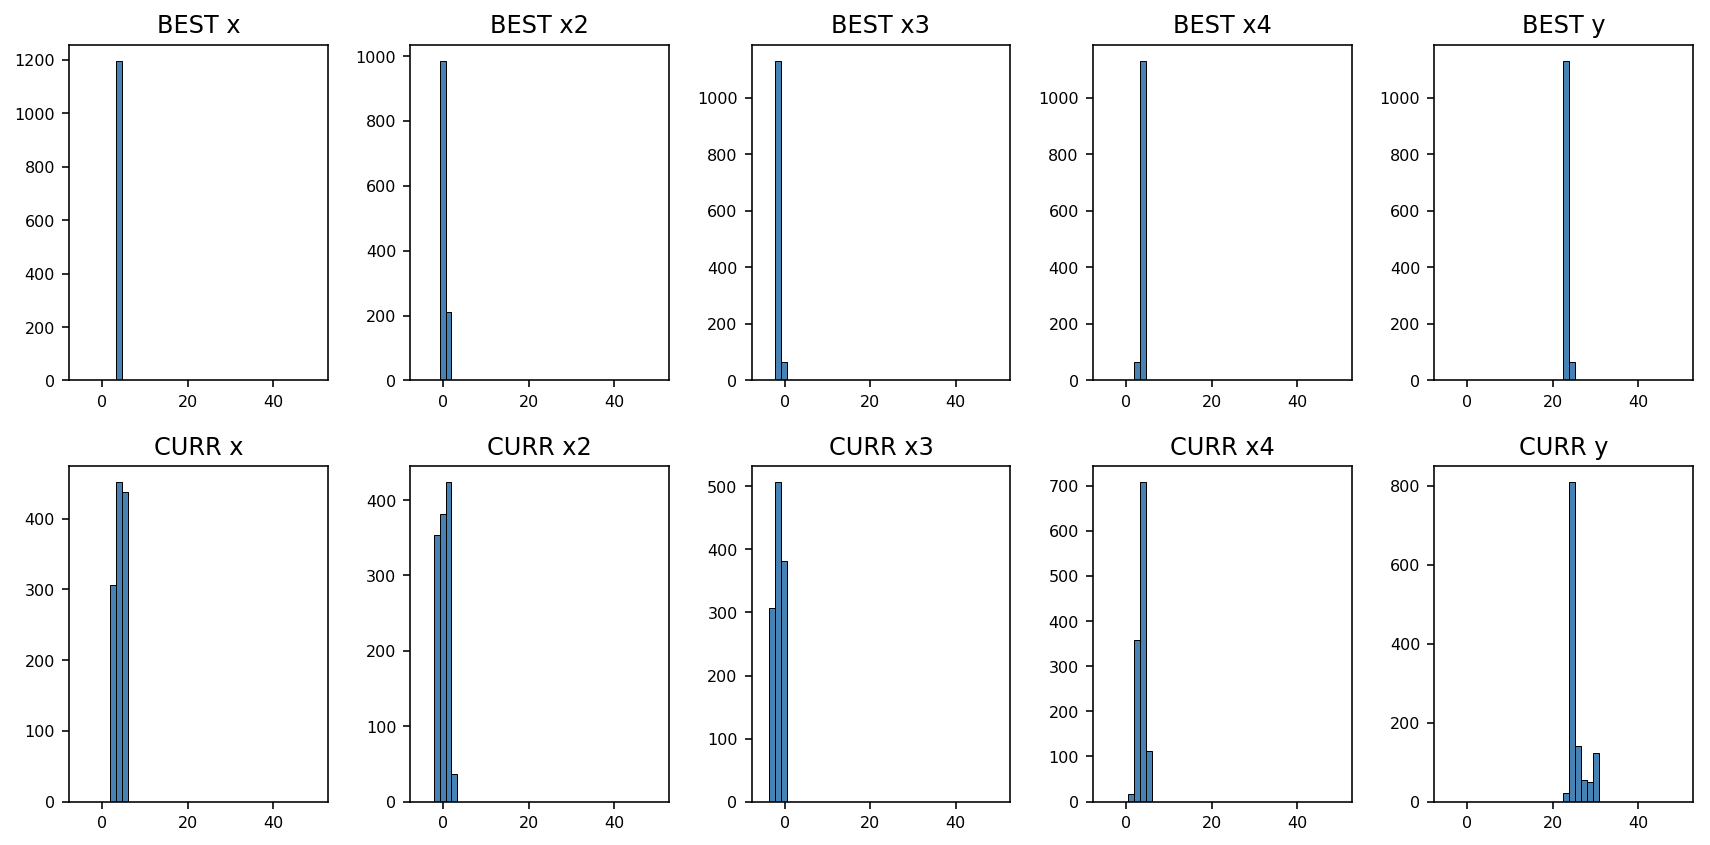

In [207]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

data.hist(bins=40, color='steelblue', edgecolor='black', linewidth=0.5,
              xlabelsize=8, ylabelsize=8, grid=False, layout=(2,5), range=[-5,50])


plt.tight_layout(rect=(0, 0.5, 2, 2))   
plt.savefig('foo.png', format='png', dpi=400)


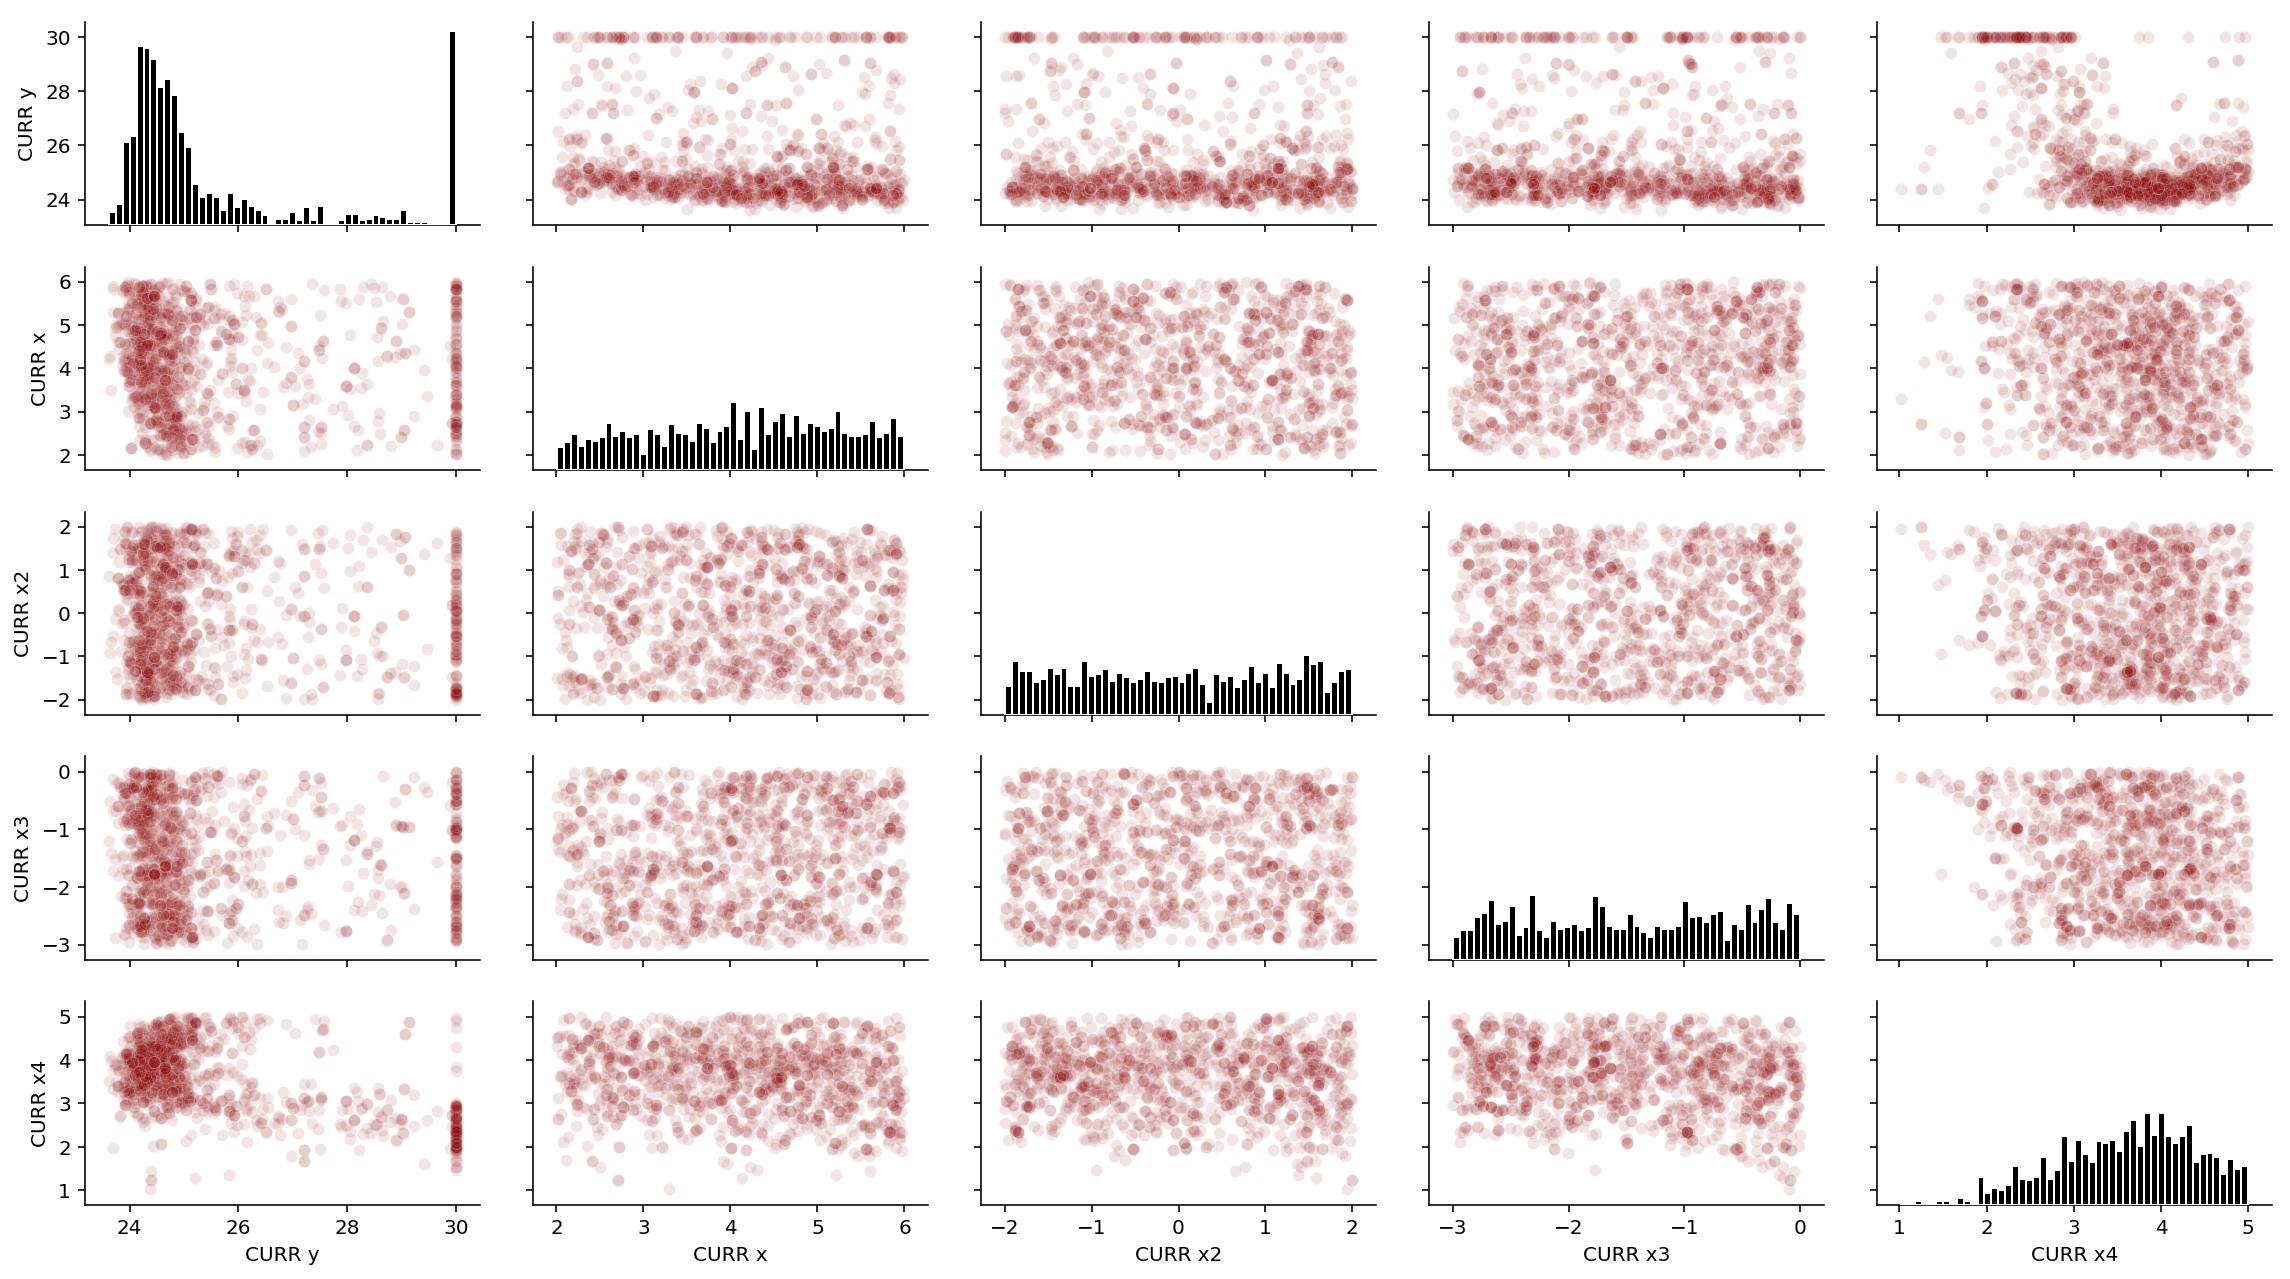

In [208]:
pp = sns.pairplot(data_cur, height=1.8, aspect=1.8,
                  plot_kws={'edgecolor':"k", 'linewidth':0.5, 'alpha':0.1, 'edgecolor': 'w', 'color':'darkred'},
                  diag_kind="hist", diag_kws={'bins':50, 'color':'black', 'edgecolor': 'w'})

A chaque fois il y a des CURRy qui sont = à l'infini au début des runs

# Parallel coordinates

In [209]:
import matplotlib.colors as colors

def truncate_colormap(cmap_str, minval=0.0, maxval=1.0, n=100):
    cmap = plt.get_cmap(cmap_str)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#arr = np.linspace(0, 50, 100).reshape((10, 10))
#fig, ax = plt.subplots(ncols=2)

#cmap_str = 'Greys'
#new_cmap = truncate_colormap(cmap, 0.1, 1)
#ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
#ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
#plt.show()

In [242]:
# redefinition of parallel_coordinates function in order to plot the color bar

def parallel_coordinates(frame, class_column, cols=None, ax=None, color=None,
                     use_columns=False, xticks=None, colormap=None,
                     **kwds):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib import cm
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap
    from collections import OrderedDict

    n = len(frame)
    class_col = frame[class_column]
    class_min = np.amin(class_col)
    class_max = np.amax(class_col)
    
    if cols is None:
        df = frame.drop(class_column, axis=1)
    else:
        df = frame[cols]

    used_legends = set([])

    ncols = len(df.columns)

    # determine values to use for xticks
    if use_columns is True:
        if not np.all(np.isreal(list(df.columns))):
            raise ValueError('Columns must be numeric to be used as xticks')
        x = df.columns
    elif xticks is not None:
        if not np.all(np.isreal(xticks)):
            raise ValueError('xticks specified must be numeric')
        elif len(xticks) != ncols:
            raise ValueError('Length of xticks must match number of columns')
        x = xticks
    else:
        x = range(ncols)

    fig = plt.figure(figsize=(20,10))
    ax = plt.gca()

    colormap = truncate_colormap(colormap, 0, 0.8)
    Colorm = plt.get_cmap(colormap)
    
    #Change the bests 10% solutions in pink
    ###
    greysR = cm.get_cmap(colormap, 256)
    newcolors = greysR(np.linspace(0, 1, 256))
    pink = np.array([248/256, 24/256, 148/256, 1])
    newcolors[:10, :] = pink
    Colorm = ListedColormap(newcolors)
    ###

    for i in range(n):
        y = df.iloc[i].values
        kls = class_col.iat[i]
        ymin=-3
        ymax=6.1
        ax.set_ylim([ymin,ymax])
        ax.plot(x, y, color=Colorm((kls - class_min)/(class_max-class_min)), alpha=0.4, **kwds)

    for i in x:
        ax.axvline(i, linewidth=1, color='black')

    ax.set_xticks(x)
    ax.set_xticklabels(df.columns)
    ax.set_xlim(x[0], x[-1])
    ax.legend(loc='upper right')
    ax.grid()
    #ax.set_facecolor('navajowhite')


    bounds = np.linspace(class_min,class_max,10)
    cax,_ = mpl.colorbar.make_axes(ax)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=Colorm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%.5f')

    return fig

####



In [243]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
print(newcolors.shape)
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[:25] = pink

print(newcolors)

(256, 4)
[[0.96875  0.09375  0.578125 1.      ]
 [0.96875  0.09375  0.578125 1.      ]
 [0.96875  0.09375  0.578125 1.      ]
 ...
 [0.974417 0.90359  0.130215 1.      ]
 [0.983868 0.904867 0.136897 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


No handles with labels found to put in legend.


Text(0, 0.5, 'CURR y values')

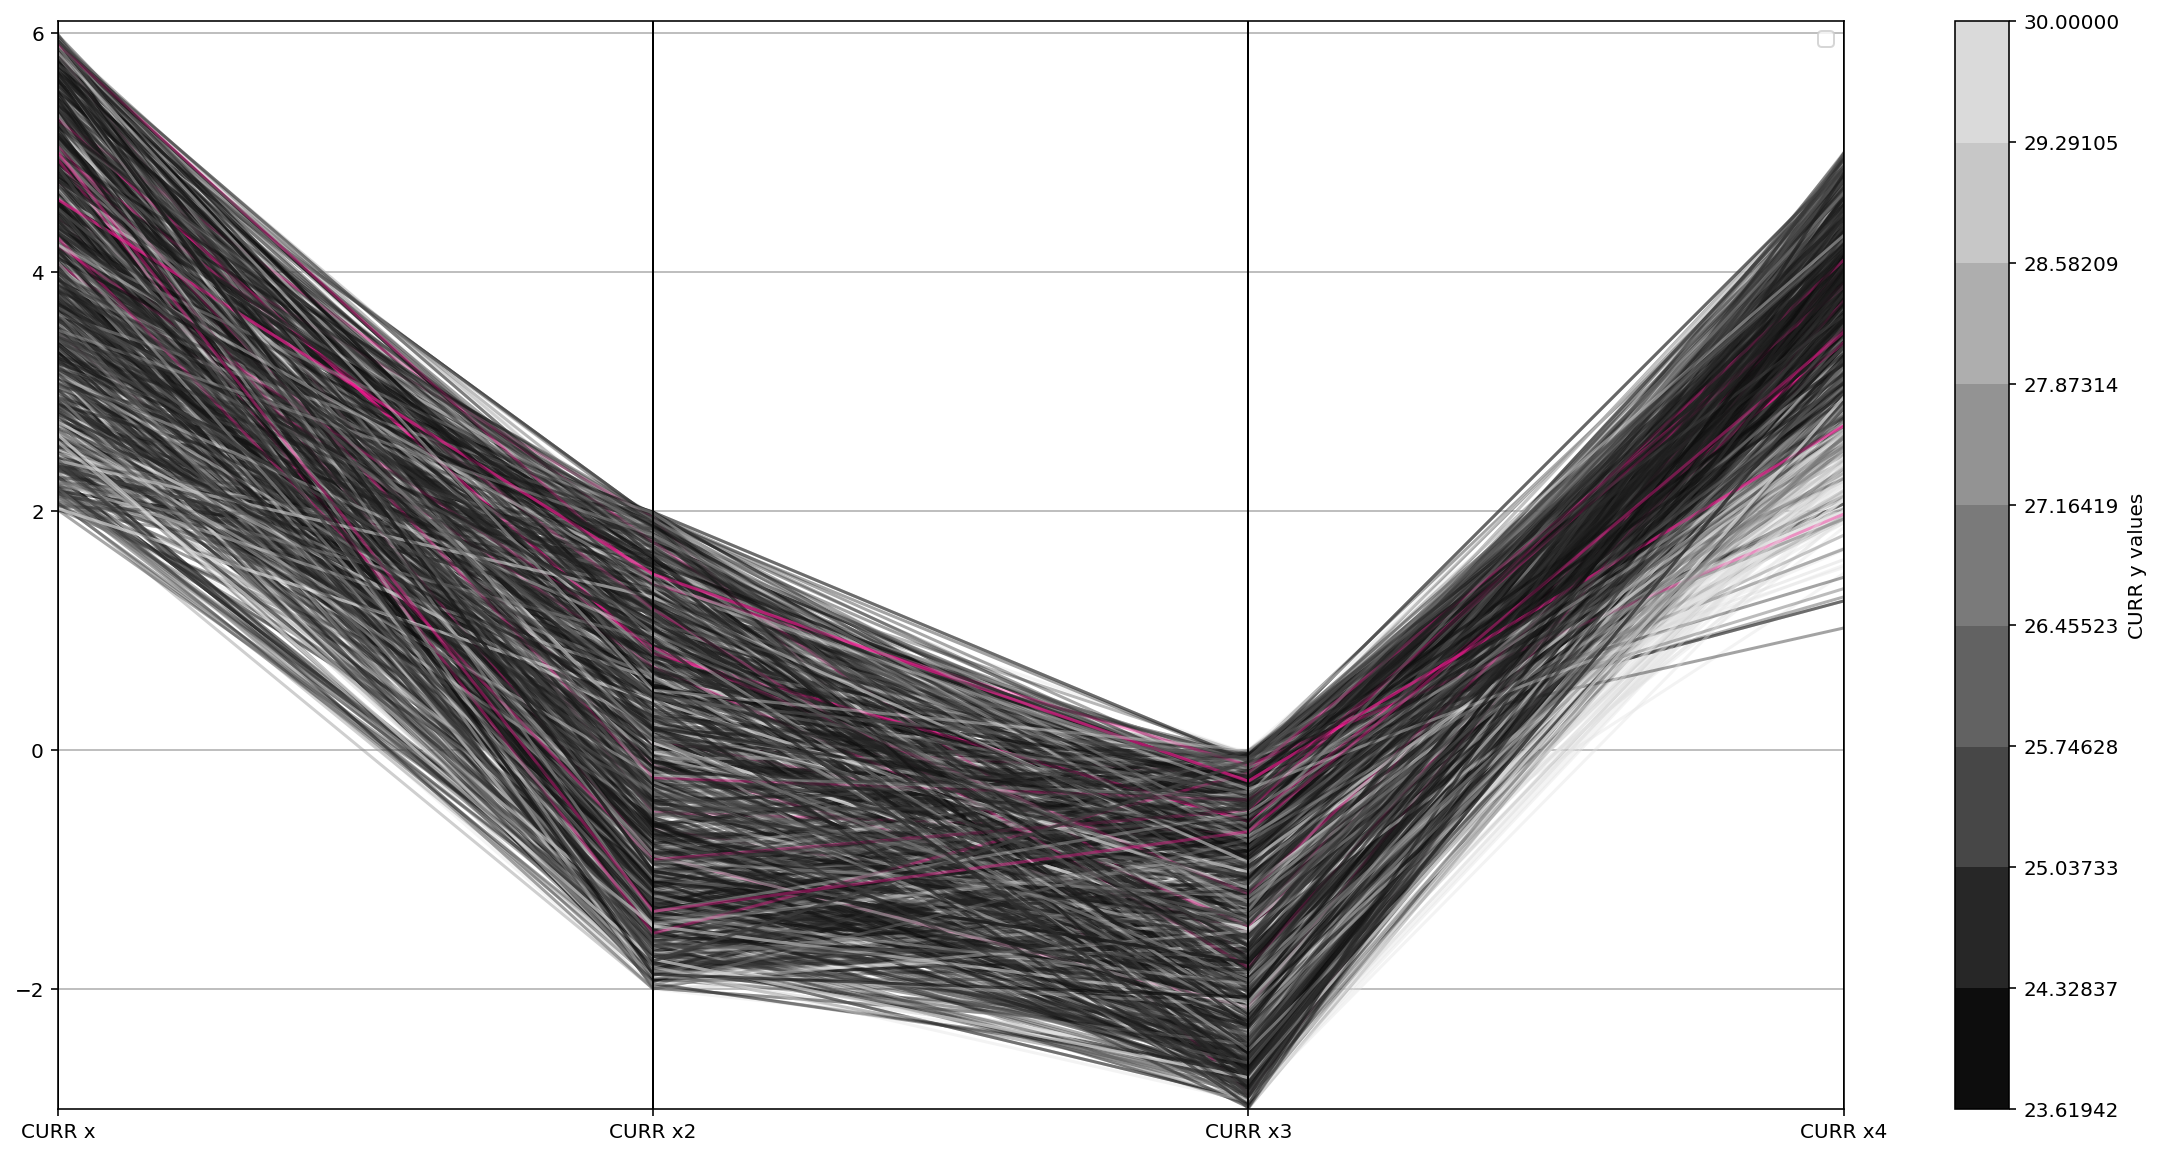

In [244]:
parallel_coordinates(data_cur, 'CURR y', colormap = 'Greys_r')
plt.ylabel("CURR y values")

# Best of 4 parrallel coordinates

In [212]:
data0, data_cur0, data_best0 = processData('../simulations/aRq0jta00_DSA_results.txt')
data1, data_cur1, data_best1 = processData('../simulations/OwnLejjl0_DSA_results.txt')
data2, data_cur2, data_best2 = processData('../simulations/UqzlklOyY_DSA_results.txt')
data3, data_cur3, data_best3 = processData('../simulations/ZF0ZAUTcE_DSA_results.txt')

isGlobalBest = data_best0['BEST y']==data_best0['BEST y'].min()
data_best0 = data_best0[isGlobalBest].head()
isGlobalBest = data_best1['BEST y']==data_best1['BEST y'].min()
data_best1 = data_best1[isGlobalBest].head()
isGlobalBest = data_best2['BEST y']==data_best2['BEST y'].min()
data_best2 = data_best2[isGlobalBest].head()
isGlobalBest = data_best3['BEST y']==data_best3['BEST y'].min()
data_best3 = data_best3[isGlobalBest].head()

data = pd.concat([data_best0,data_best1,data_best2,data_best3])

/Users/leobouraux/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [213]:
data

BEST y    BEST x   BEST x2   BEST x3   BEST x4
113   23.743445  5.417985 -1.913749 -0.935984  3.975210
114   23.743445  5.417985 -1.913749 -0.935984  3.975210
115   23.743445  5.417985 -1.913749 -0.935984  3.975210
116   23.743445  5.417985 -1.913749 -0.935984  3.975210
117   23.743445  5.417985 -1.913749 -0.935984  3.975210
1020  23.619419  4.220779  0.859727 -1.200206  3.525576
1021  23.619419  4.220779  0.859727 -1.200206  3.525576
1022  23.619419  4.220779  0.859727 -1.200206  3.525576
1023  23.619419  4.220779  0.859727 -1.200206  3.525576
1024  23.619419  4.220779  0.859727 -1.200206  3.525576
182   23.730676  4.640577  0.267599 -1.697751  3.559573
183   23.730676  4.640577  0.267599 -1.697751  3.559573
184   23.730676  4.640577  0.267599 -1.697751  3.559573
185   23.730676  4.640577  0.267599 -1.697751  3.559573
186   23.730676  4.640577  0.267599 -1.697751  3.559573
498   23.637704  5.305201 -0.908469 -0.594510  3.869780
499   23.637704  5.305201 -0.908469 -0.594510  3.869780
500   23.637704  5.305201 -0.908469 -0.594510  3.869780
501   23.637704  5.305201 -0.908469 -0.594510  3.869780
502   23.637704  5.305201 -0.908469 -0.594510  3.869780

No handles with labels found to put in legend.


Text(0, 0.5, 'BEST y values')

<Figure size 432x288 with 0 Axes>

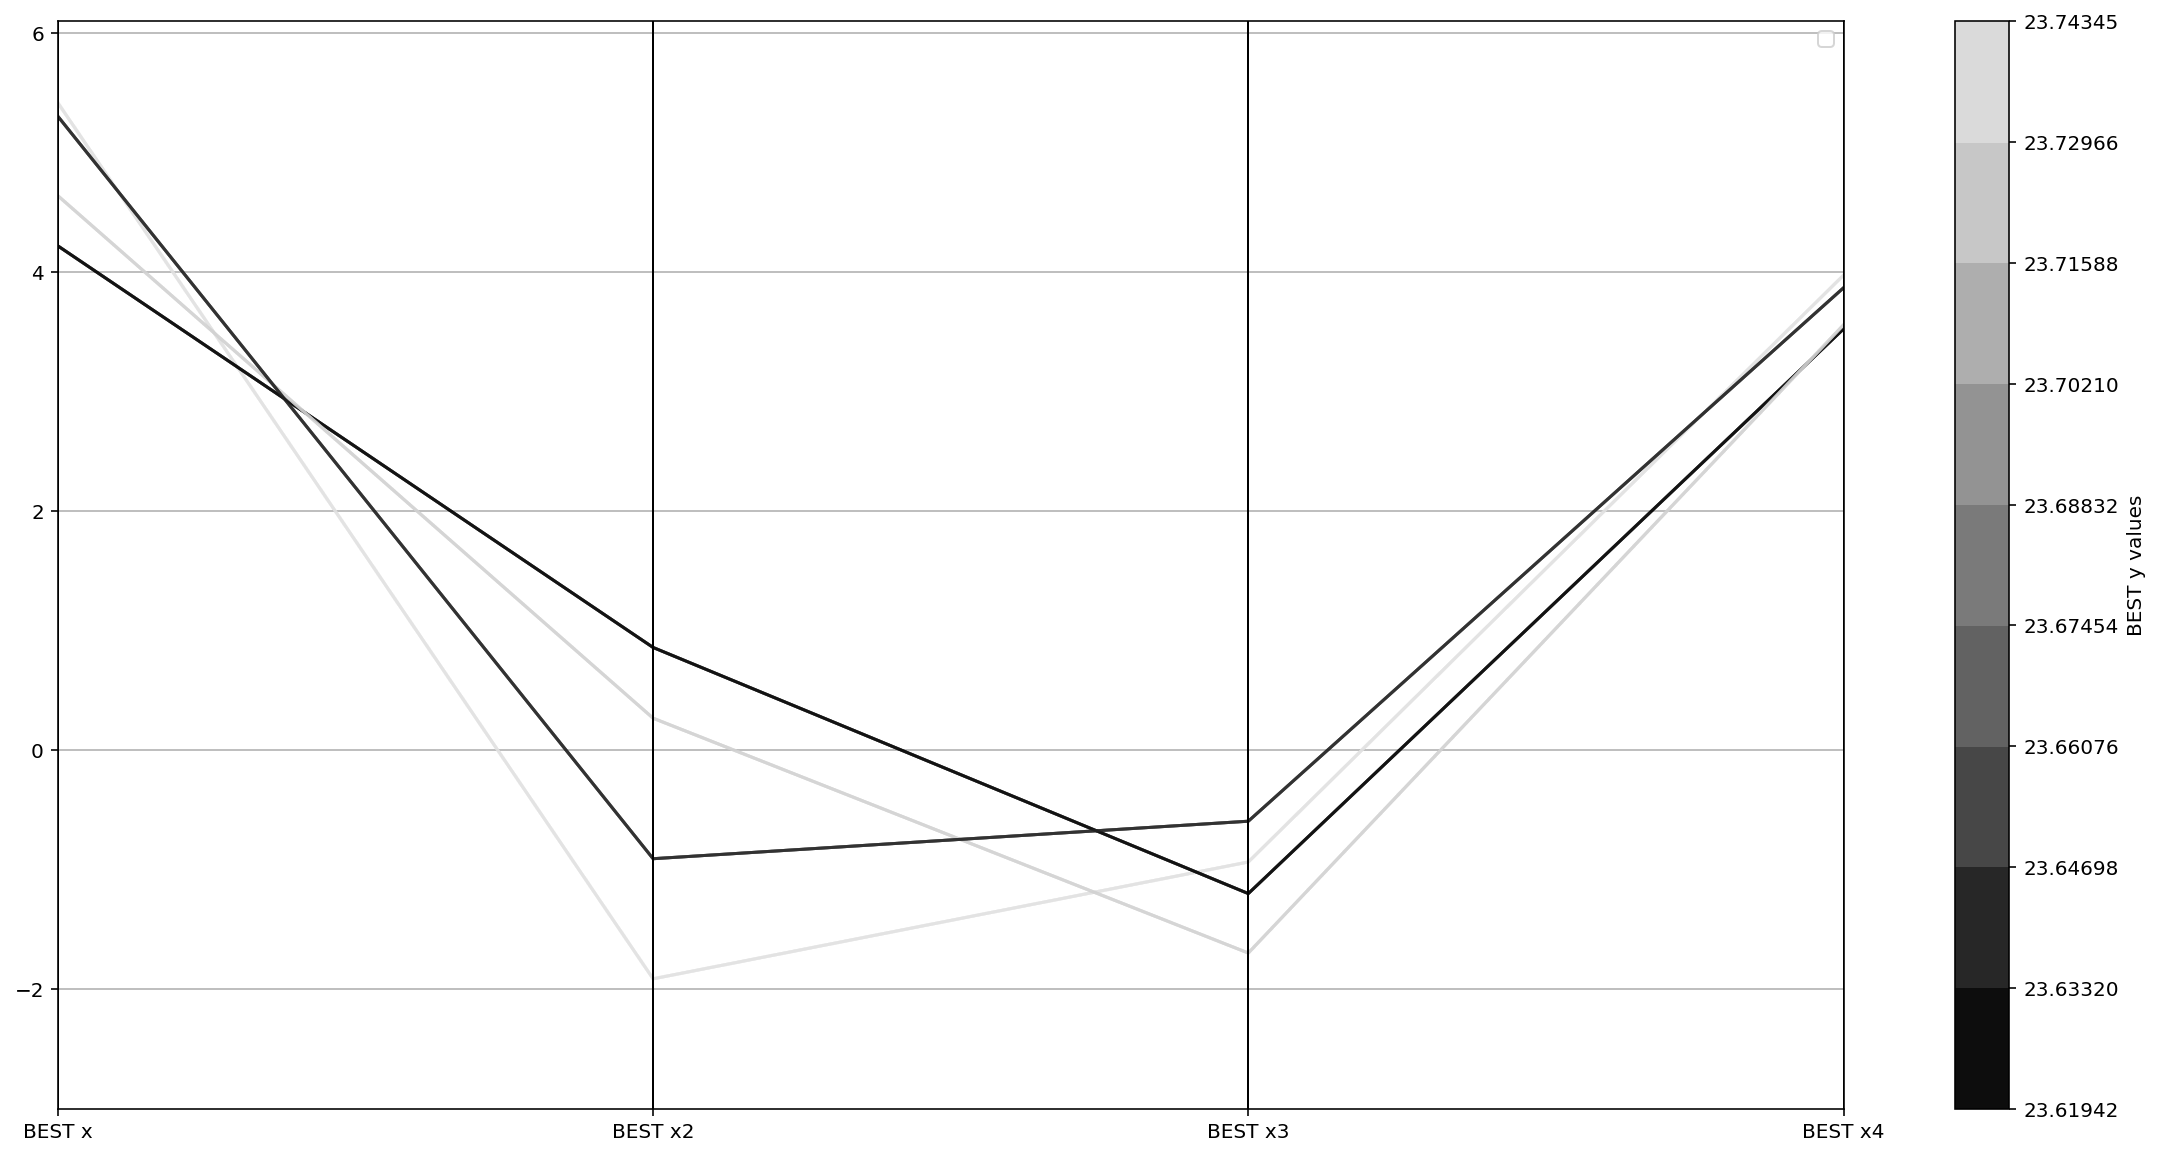

In [214]:
plt.close()
plt.gcf().clear()    

parallel_coordinates(data, 'BEST y', colormap = 'Greys_r')
plt.ylabel("BEST y values")

# Run DATA REFERENCE # Median travel time


In [166]:
import pandas as pd 
data = pd.read_csv('../../../../GraphsSimu/data_référence_without_gates/intersection-no-gates_median-travel-time-per-simulation-by-OD.csv') 
data.head()

withGates  withoutGates
0  20.926556     24.817283
1  21.285168     23.716504
2  21.383386     23.417160
3  23.084555     28.587922
4  23.170005     28.448062

In [167]:
data = data.drop(data.index[[200]])

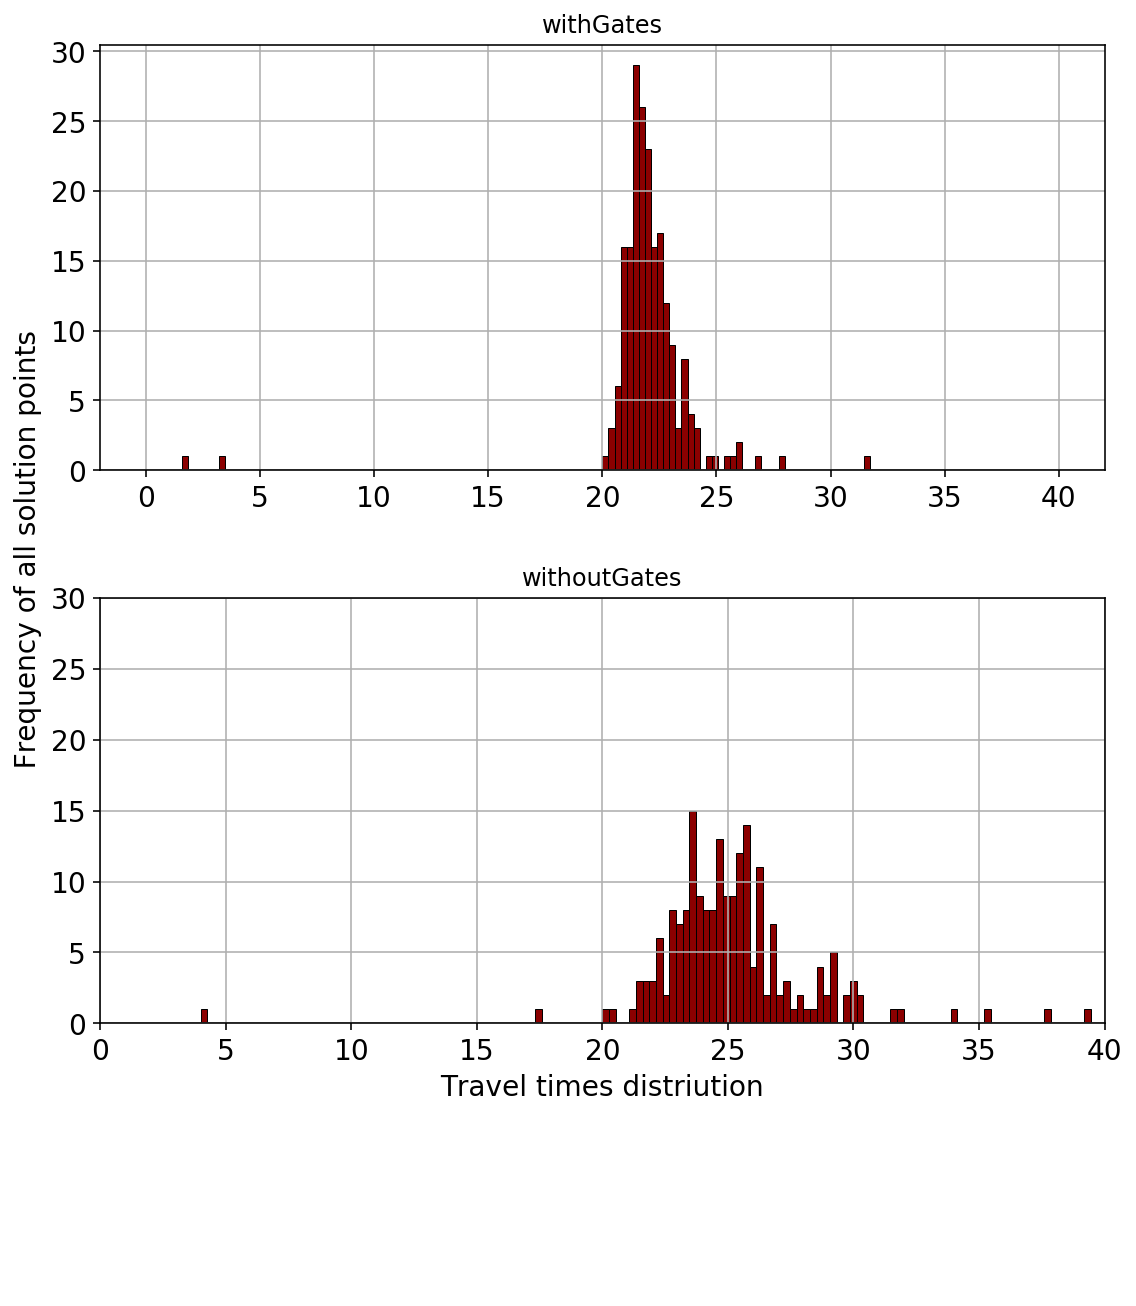

In [155]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

data.hist(bins=150, color='darkred', edgecolor='black', linewidth=0.5, figsize=(9, 9), 
              xlabelsize=14, ylabelsize=14, grid=True, layout=(2, 1), range=[0,40])
#plt.tight_layout()

plt.xlabel('Travel times distriution', fontsize=14)
plt.ylabel('                                                           Frequency of all solution points', fontsize=14)
plt.ylim([0, 30])
plt.xlim([0, 40])

plt.savefig('/Users/leobouraux/Desktop/foo1.png', format='png', dpi=333)


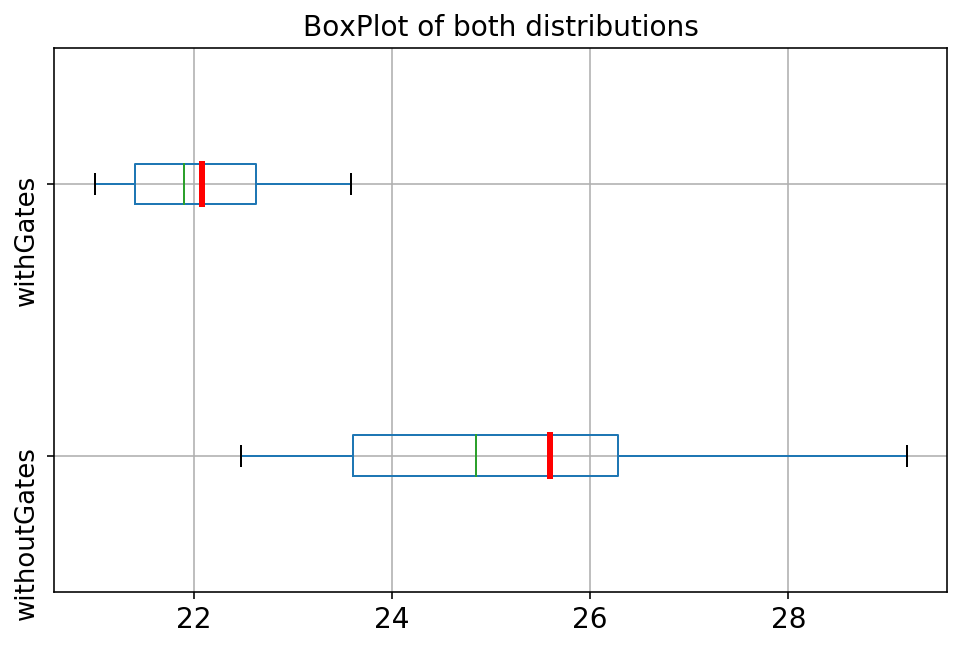

In [170]:
meanlineprops = dict(linestyle='-', linewidth=3, color='red')

f, (ax2) = plt.subplots(1, 1, sharey=True, figsize=(8, 5))

data.boxplot(column=['withoutGates', 'withGates'], ax = ax2, showfliers=False, vert=False,
             whis=[10, 90], showmeans=True, meanline=True,
             meanprops=meanlineprops)

ax2.tick_params(axis='x', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=13)
plt.yticks(rotation=90)

plt.title('BoxPlot of both distributions', size=14)

plt.savefig('/Users/leobouraux/Desktop/foo1.png', format='png', dpi=333)


<Figure size 432x288 with 0 Axes>

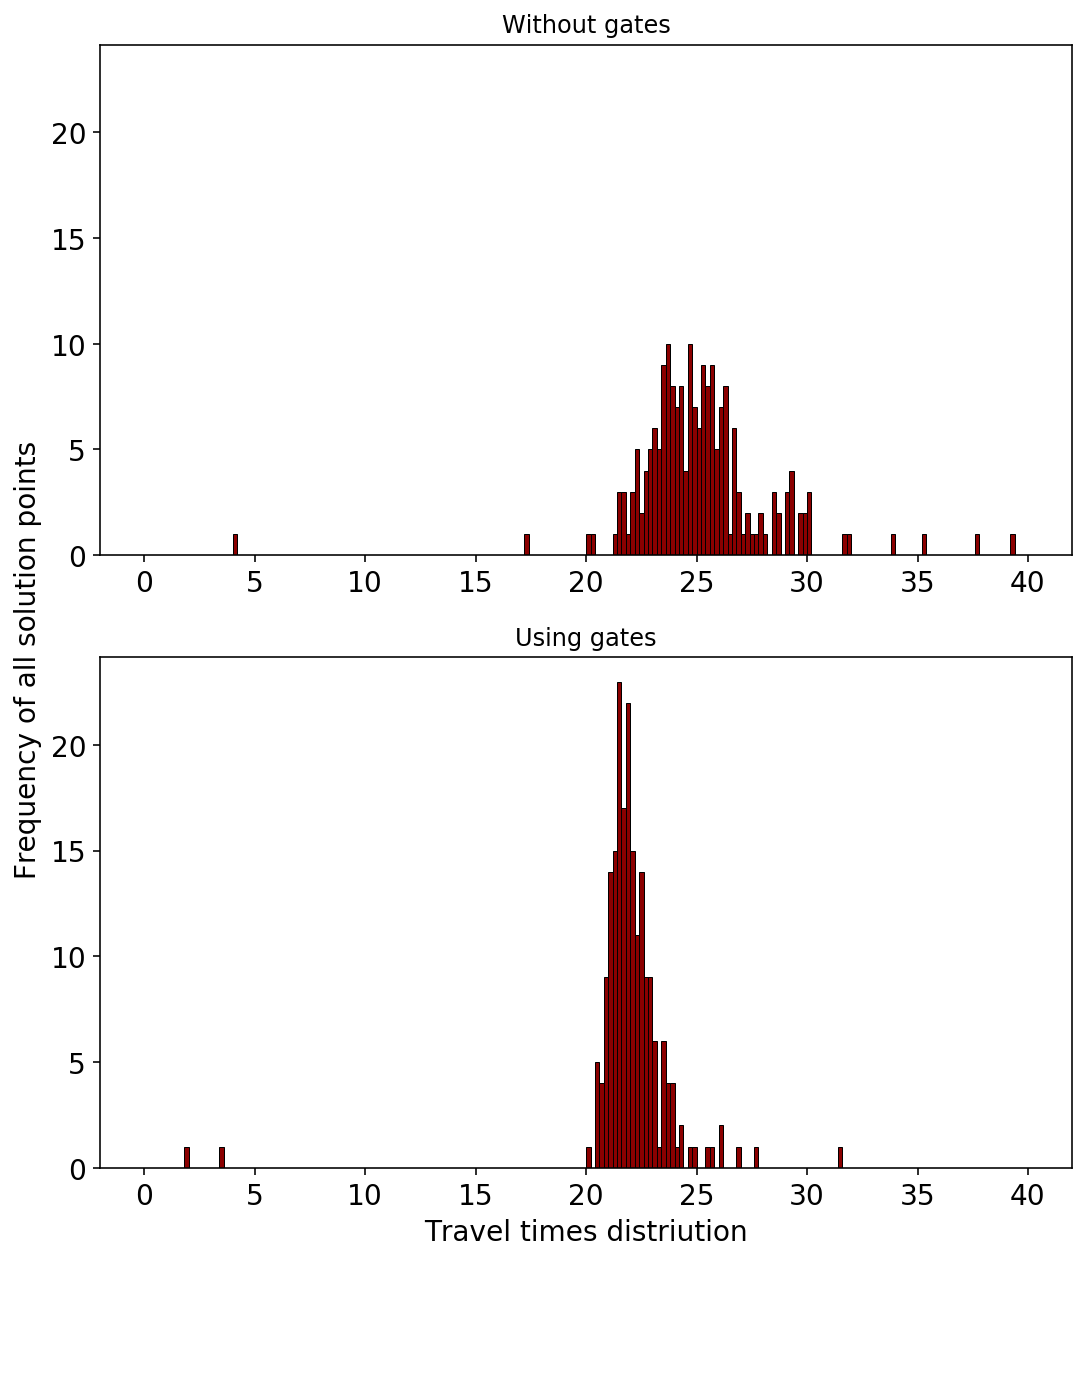

In [157]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

plt.savefig('/Users/leobouraux/Desktop/foo.png', format='png', dpi=333)



f, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=(10, 6))
f.subplots_adjust(bottom=0.1, right=0.8, top=1.4)


data['withoutGates'].hist(bins=200, color='darkred', ax=ax1, edgecolor='black', linewidth=0.5,
              xlabelsize=8, ylabelsize=8, grid=False, range=[0,40])

ax1.tick_params(axis='x', which='major', labelsize=14)
ax1.tick_params(axis='y', which='major', labelsize=14)
ax1.set_title('Without gates') 

data['withGates'].hist(bins=200, color='darkred', ax=ax2, edgecolor='black', linewidth=0.5,
              xlabelsize=8, ylabelsize=8, grid=False, range=[0,40])

ax2.tick_params(axis='x', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=14)
ax2.set_title('Using gates') 


plt.xlabel('Travel times distriution', fontsize=14)
plt.ylabel('                                                         Frequency of all solution points', fontsize=14)


plt.savefig('/Users/leobouraux/Desktop/foo1.png', format='png', dpi=333)

plt.show()

In [158]:
data.describe()

withGates  withoutGates
count  204.000000    204.000000
mean    22.085522     25.599278
std      2.669919      4.433945
min      1.851057      4.169191
25%     21.403988     23.603622
50%     21.906615     24.846680
75%     22.626940     26.279142
max     40.336861     53.236656

In [2]:
def SixPlots(data):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 6))

    data['allPedsTTmedmed'].plot.hist(bins=100, ax=ax1, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    f.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    data['withGatesTTmedmed'].plot.hist(bins=100, ax=ax2, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    f.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    data['withoutGatesTTmedmed'].plot.hist(bins=100, ax=ax3, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    f.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

    ax1.set_title('allPedsTTmedmed')
    ax2.set_title('withGatesTTmedmed') 
    ax3.set_title('withoutGatesTTmedmed') 
    
    plt.savefig('../resources/foo1.png', format='png', dpi=333)


    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 6))

    data['allPedsTTvarmed'].plot.hist(bins=100, ax=ax1, color='darkgreen', edgecolor='black', linewidth=0.5, range=[5,60]) 
    f.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    data['withGatesTTvarmed'].plot.hist(bins=100, ax=ax2, color='darkgreen', edgecolor='black', linewidth=0.5, range=[5,60]) 
    f.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    data['withoutGatesTTvarmed'].plot.hist(bins=100, ax=ax3, color='darkgreen', edgecolor='black', linewidth=0.5, range=[5,60]) 
    f.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

    ax1.set_title('allPedsTTvarmed')
    ax2.set_title('withGatesTTvarmed') 
    ax3.set_title('withoutGatesTTvarmed')
    
    plt.savefig('../resources/foo2.png', format='png', dpi=333)


In [3]:
def FOURSIMU(datas, isMEDMED):
    
    data1 = datas[0]
    data2 = datas[1]
    data3 = datas[2]
    data4 = datas[3]
    
    if(isMEDMED):
        st = 'medmed'
        c = 'steelblue'
    else:
        st = 'varmed'
        c = 'darkgreen'
    
    f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, sharey=True, figsize=(20, 20))
    
    data1['allPedsTT'+st].plot.hist(bins=100, ax=ax1, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    data2['allPedsTT'+st].plot.hist(bins=100, ax=ax2, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    data3['allPedsTT'+st].plot.hist(bins=100, ax=ax3, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    data4['allPedsTT'+st].plot.hist(bins=100, ax=ax4, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    ax1.set_title('allPedsTT'+st+'1')
    ax2.set_title('allPedsTT'+st+'2')
    ax3.set_title('allPedsTT'+st+'3')
    ax4.set_title('allPedsTT'+st+'4')
    data1['withGatesTT'+st].plot.hist(bins=100, ax=ax5, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    data2['withGatesTT'+st].plot.hist(bins=100, ax=ax6, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    data3['withGatesTT'+st].plot.hist(bins=100, ax=ax7, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    data4['withGatesTT'+st].plot.hist(bins=100, ax=ax8, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    ax5.set_title('withGatesTT'+st+'5') 
    ax6.set_title('withGatesTT'+st+'6') 
    ax7.set_title('withGatesTT'+st+'7') 
    ax8.set_title('withGatesTT'+st+'8') 
    data1['withoutGatesTT'+st].plot.hist(bins=100, ax=ax9, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    data2['withoutGatesTT'+st].plot.hist(bins=100, ax=ax10, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    data3['withoutGatesTT'+st].plot.hist(bins=100, ax=ax11, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    data4['withoutGatesTT'+st].plot.hist(bins=100, ax=ax12, color=c, edgecolor='black', linewidth=0.5, range=[20,45]) 
    ax9.set_title('withoutGatesTT'+st+'9') 
    ax10.set_title('withoutGatesTT'+st+'10') 
    ax11.set_title('withoutGatesTT'+st+'11') 
    ax12.set_title('withoutGatesTT'+st+'12') 
    
    plt.savefig('../resources/foo.png', format='png', dpi=333)


In [11]:
def THREE_DIF_PARAM(datas):
    
    data1 = datas[0] #107
    data2 = datas[1] #217
    data3 = datas[2] #with
    
    st='medmed'
    
    f, ((ax1, ax2, ax3),
        (ax4, ax5, ax6),
        (ax7, ax8, ax9),
        (ax10, ax11, ax12), 
        (ax13, ax14, ax15), 
        (ax16, ax17, ax18)) = plt.subplots(6, 3, sharey=True, figsize=(20, 20))
    
    data1['allPedsTT'+st].plot.hist(bins=200, ax=ax1, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    data2['allPedsTT'+st].plot.hist(bins=200, ax=ax2, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    data3['allPedsTT'+st].plot.hist(bins=200, ax=ax3, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    ax1.set_title('allPedsTT'+st+' dens 107')
    ax2.set_title('allPedsTT'+st+' dens 217')
    ax3.set_title('allPedsTT'+st+' with den')
    data1['withGatesTT'+st].plot.hist(bins=200, ax=ax4, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    data2['withGatesTT'+st].plot.hist(bins=200, ax=ax5, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    data3['withGatesTT'+st].plot.hist(bins=200, ax=ax6, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    ax4.set_title('withGatesTT'+st+' dens 107')
    ax5.set_title('withGatesTT'+st+' dens 217')
    ax6.set_title('withGatesTT'+st+' with den')
    data1['withoutGatesTT'+st].plot.hist(bins=200, ax=ax7, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    data2['withoutGatesTT'+st].plot.hist(bins=200, ax=ax8, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    data3['withoutGatesTT'+st].plot.hist(bins=200, ax=ax9, color='steelblue', edgecolor='black', linewidth=0.5, range=[20,45]) 
    ax7.set_title('withoutGatesTT'+st+' dens 107')
    ax8.set_title('withoutGatesTT'+st+' dens 217')
    ax9.set_title('withoutGatesTT'+st+' with den')
    
    st='varmed'
    
    data1['allPedsTT'+st].plot.hist(bins=200, ax=ax10, color='darkgreen', edgecolor='black', linewidth=0.5, range=[8,40]) 
    data2['allPedsTT'+st].plot.hist(bins=200, ax=ax11, color='darkgreen', edgecolor='black', linewidth=0.5, range=[8,40]) 
    data3['allPedsTT'+st].plot.hist(bins=200, ax=ax12, color='darkgreen', edgecolor='black', linewidth=0.5, range=[8,40]) 
    ax10.set_title('allPedsTT'+st+' dens 107')
    ax11.set_title('allPedsTT'+st+' dens 217')
    ax12.set_title('allPedsTT'+st+' with den')
    data1['withGatesTT'+st].plot.hist(bins=200, ax=ax13, color='darkgreen', edgecolor='black', linewidth=0.5, range=[8,40]) 
    data2['withGatesTT'+st].plot.hist(bins=200, ax=ax14, color='darkgreen', edgecolor='black', linewidth=0.5, range=[8,40]) 
    data3['withGatesTT'+st].plot.hist(bins=200, ax=ax15, color='darkgreen', edgecolor='black', linewidth=0.5, range=[8,40]) 
    ax13.set_title('withGatesTT'+st+' dens 107')
    ax14.set_title('withGatesTT'+st+' dens 217')
    ax15.set_title('withGatesTT'+st+' with den')
    data1['withoutGatesTT'+st].plot.hist(bins=200, ax=ax16, color='darkgreen', edgecolor='black', linewidth=0.5, range=[8,40]) 
    data2['withoutGatesTT'+st].plot.hist(bins=200, ax=ax17, color='darkgreen', edgecolor='black', linewidth=0.5, range=[8,40]) 
    data3['withoutGatesTT'+st].plot.hist(bins=200, ax=ax18, color='darkgreen', edgecolor='black', linewidth=0.5, range=[8,40]) 
    ax16.set_title('withoutGatesTT'+st+' dens 107')
    ax17.set_title('withoutGatesTT'+st+' dens 217')
    ax18.set_title('withoutGatesTT'+st+' with den')
    
    plt.savefig('../resources/foo.png', format='png', dpi=333)



# DATA with fixed density threshold 1.07

In [12]:
import pandas as pd 
data = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-107/SO_gating_KPIs_GC8CyF4Uu.csv') 
data = data.dropna()
data

allPedsTTmedmed  allPedsTTvarmed  allPedsSize  withGatesTTmedmed  \
0           27.738916        15.771428      34116.0          30.178188   
1           29.526339        20.234409      34554.0          32.719613   
2           30.272339        23.804113      34589.0          33.947639   
3           32.572527        28.689718      34933.0          36.218910   
4           30.771494        22.992835      34628.0          34.191613   
5           29.241223        19.488434      34288.0          32.785985   
6           31.108338        24.562514      34532.0          35.086897   
7           31.191197        25.910908      34369.0          35.350692   
8           29.217050        18.552086      33985.0          32.578244   
9           30.190637        21.752393      34363.0          32.929525   
10          29.842606        19.984250      34439.0          33.307100   
11          36.737536        39.646533      34588.0          39.866047   
12          32.823587        28.849353      34175.0          37.040416   
13          30.290998        21.830375      35154.0          34.166060   
14          28.788604        17.747374      33961.0          32.060736   
15          29.645910        20.062343      33893.0          33.387994   
16          29.941398        21.424183      34249.0          33.528698   
17          28.050709        15.558776      34349.0          30.322457   
18          31.832668        28.380630      34416.0          36.949052   
19          32.431347        30.946324      34708.0          36.247674   
20          30.539397        23.744509      33861.0          34.504824   
21          31.047321        25.995242      34150.0          35.410460   
22          34.810119        34.692738      34288.0          38.891688   
23          30.818102        24.801995      34681.0          34.737657   
24          31.856350        27.788867      34020.0          35.953754   
25          31.561270        27.661380      34204.0          35.594454   
26          32.855612        29.734654      33408.0          36.455188   
27          30.888126        24.189342      34260.0          35.187531   
28          28.421011        16.730871      34477.0          31.420120   
29          38.337894        42.237346      34452.0          41.356301   
...               ...              ...          ...                ...   
1413        30.704466        23.796546      34837.0          35.052807   
1414        29.608717        19.521910      34727.0          33.786901   
1415        23.380773        12.051385      34475.0          23.168219   
1416        31.808676        27.585769      34769.0          36.171721   
1417        24.188651        11.909903      34543.0          24.400298   
1418        24.096281        12.228516      34838.0          24.076710   
1419        23.438129        13.540189      34175.0          23.029243   
1420        29.099910        17.948561      34856.0          32.364502   
1421        34.996883        36.736092      35020.0          39.492951   
1422        29.740149        21.431654      34390.0          33.662417   
1423        29.167300        19.586744      34344.0          32.278283   
1424        35.873923        40.097538      34540.0          40.056470   
1425        23.538447        14.314276      34494.0          23.159225   
1426        29.315728        20.273330      34024.0          32.861266   
1427        29.171952        18.818858      34592.0          32.501037   
1428        23.638425        11.636142      33703.0          23.574010   
1429        23.125727        13.550932      34574.0          22.713357   
1430        41.231323        46.556244      34454.0          43.522976   
1431        23.196387        12.392230      33913.0          22.676583   
1432        28.896493        16.363423      34382.0          31.967635   
1433        27.663070        14.852525      34253.0          30.409589   
1434        32.266645        31.492948      34498.0          36.753484   
1435      

In [13]:
data.describe()

allPedsTTmedmed  allPedsTTvarmed   allPedsSize  withGatesTTmedmed  \
count      1430.000000      1430.000000   1430.000000        1430.000000   
mean         29.113046        21.269533  34379.583217          31.694139   
std           4.055529         8.577883    288.094218           5.519027   
min          22.565150        10.972959  33081.000000          22.206963   
25%          25.954098        13.809237  34193.250000          27.394382   
50%          29.453341        19.518693  34392.000000          32.929677   
75%          31.189072        25.634285  34574.000000          35.331799   
max          41.858497        46.556244  35284.000000          44.126263   

       withoutGatesTTmedmed  withGatesTTvarmed  withoutGatesTTvarmed  
count           1430.000000        1430.000000           1430.000000  
mean              23.239210          17.948465             24.474375  
std                1.636448           5.737833             10.044727  
min               21.476440           9.591966             12.017129  
25%               22.127890          12.600548             16.494845  
50%               22.494314          17.451754             21.096451  
75%               23.883028          21.376165             30.123228  
max               29.765366          32.983784             52.335800

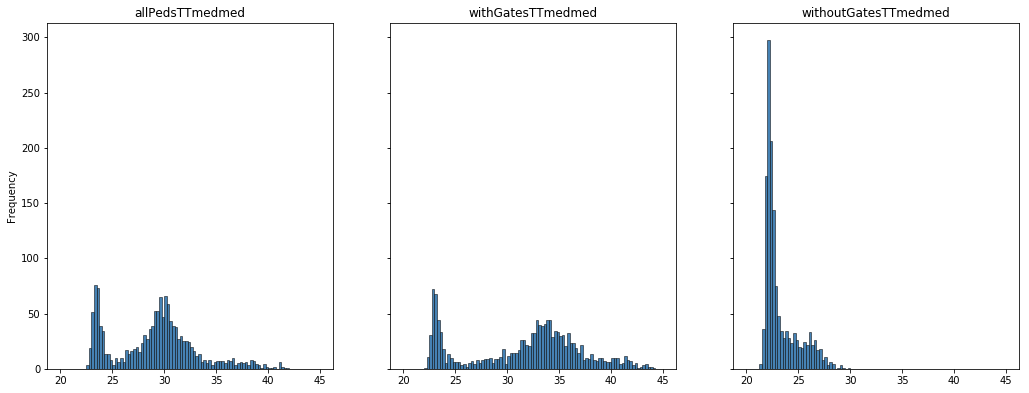

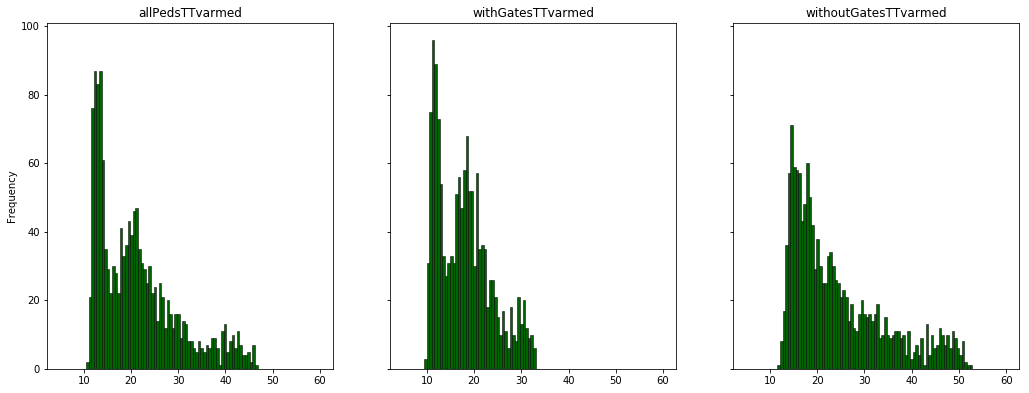

In [14]:
SixPlots(data)

----
### 4 different runs 

In [373]:
def processData4D_panda(pathTXT):
    a = []
    tab = []
    i = 0
    with open(pathTXT, "r") as file:
        for line in file:
            if(line.startswith("Runtime")):
                runtime = float(re.sub("[^0-9^.]", "", line))
            elif(line.startswith("Nbr")):
                iteration_nbr = int(re.sub("[^0-9]", "", line))
            else:
                a = line.split("|")
                a = [i.strip() for i in a][:-1]
                if(i!=0):
                    a = [float(i) for i in a]
                tab.append(a)
            i+=1
            
    titles = tab[0]    
    col_to_del = titles[:5]
    dtf = pd.DataFrame(data=tab[1:],columns=titles)
    afterdrop_all = dtf.drop(col_to_del, axis = 1)

    col_to_del = titles[:5]+titles[5::2]
    afterdrop_cur = dtf.drop(col_to_del, axis = 1)
    
    col_to_del = titles[:5]+titles[6::2]
    afterdrop_bes = dtf.drop(col_to_del, axis = 1)
    
    isCG = dtf['Control-G?']==1.0
    col_to_del = titles[:5]+titles[5::2]
    afterdrop_curCG = dtf[isCG].drop(col_to_del, axis = 1)
    
    return afterdrop_all

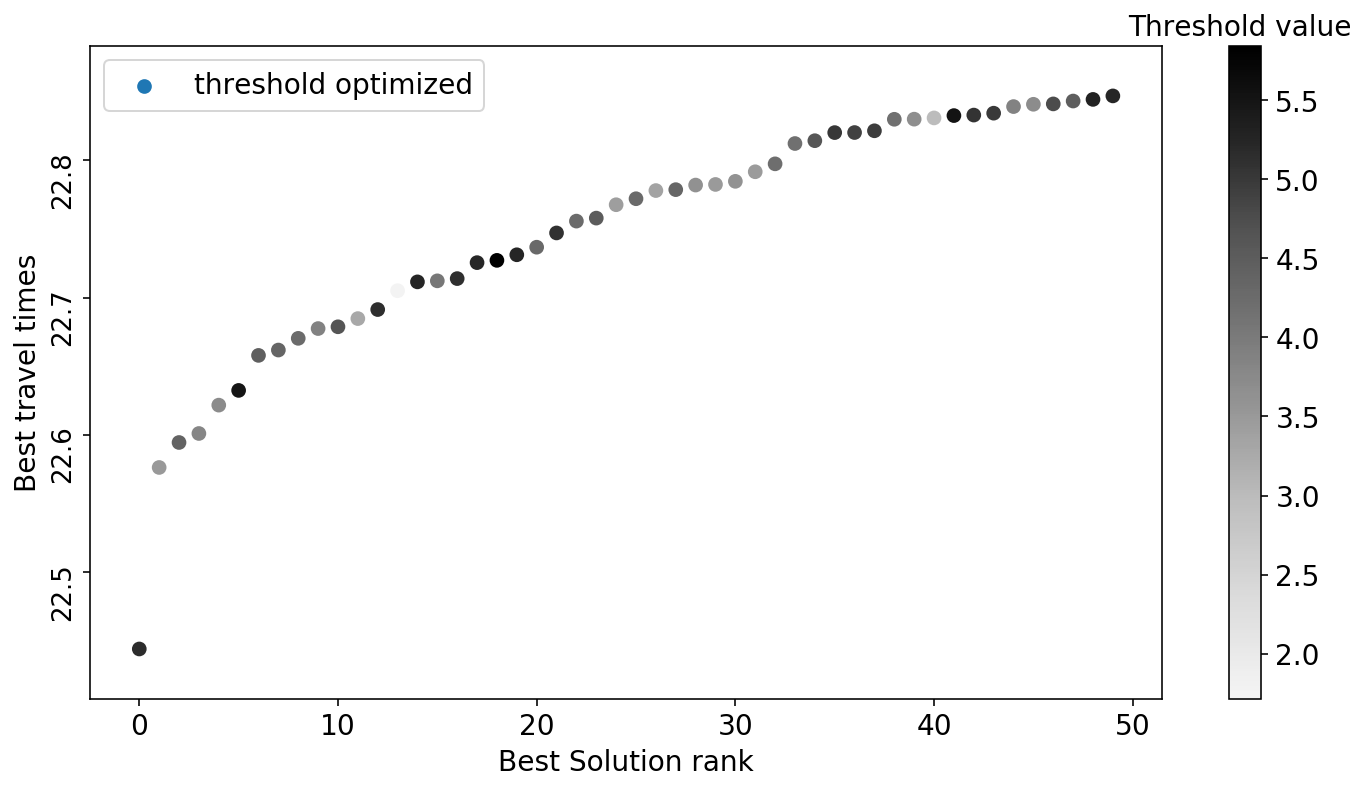

[22.44415535758717, 22.57630744299193, 22.594487015333577, 22.601043903290915, 22.621689912539807, 22.63240515516061, 22.657899529690386, 22.66179601281024, 22.67031629467575, 22.677439197024487, 22.678730169015036, 22.684696449986237, 22.691274245443484, 22.70500413231163, 22.711431602791354, 22.71218175094331, 22.713812848123695, 22.72543485553235, 22.727089375864963, 22.73115568463418, 22.736671236909043, 22.74705260226072, 22.755666799173554, 22.7578506815493, 22.76758867444861, 22.77196188937005, 22.777909970227572, 22.77857170995767, 22.78191107675933, 22.78236197633921, 22.784628999336, 22.79159463432889, 22.797364373900248, 22.812165700855523, 22.814205437254643, 22.82011300949692, 22.820159965848433, 22.821428170272604, 22.82980615632199, 22.829894362434267, 22.830794550559936, 22.832499118794765, 22.832867152978412, 22.83424471164698, 22.839053690823604, 22.840728706699306, 22.840999018886308, 22.843091595442253, 22.84427979192557, 22.846822138128783]


In [401]:
import pandas as pd 
data107_1 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-107/SO_gating_KPIs_GC8CyF4Uu.csv') 
data107_1 = data107_1.dropna()
data107_1 = data107_1.sort_values(by=['allPedsTTmedmed'])[:100]

data107_2 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-107/SO_gating_KPIs_ivzG734x1.csv') 
data107_2 = data107_2.dropna()
data107_2 = data107_2.sort_values(by=['allPedsTTmedmed'])[:100]

data107_3 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-107/SO_gating_KPIs_pVbSUp6y0.csv') 
data107_3 = data107_3.dropna()
data107_3 = data107_3.sort_values(by=['allPedsTTmedmed'])[:100]

data107_4 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-107/SO_gating_KPIs_qUQP7GXjq.csv') 
data107_4 = data107_4.dropna()
data107_4 = data107_4.sort_values(by=['allPedsTTmedmed'])[:100]

data107_s = data107_1.append(data107_2).append(data107_3).append(data107_4)
data107_s0 = data107_s.sort_values(by=['allPedsTTmedmed'])
data107_s1 = data107_s.sort_values(by=['withGatesTTmedmed'])
data107_s2 = data107_s.sort_values(by=['withoutGatesTTmedmed'])




data207_1 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-217/SO_gating_KPIs_MDaWZEnIO.csv') 
data207_1 = data207_1.dropna()
data207_1 = data207_1.sort_values(by=['allPedsTTmedmed'])[:100]

data207_2 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-217/SO_gating_KPIs_p0sPw3OYQ.csv') 
data207_2 = data207_2.dropna()
data207_2 = data207_2.sort_values(by=['allPedsTTmedmed'])[:100]

data207_3 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-217/SO_gating_KPIs_xDiJTm1yP.csv') 
data207_3 = data207_3.dropna()
data207_3 = data207_3.sort_values(by=['allPedsTTmedmed'])[:100]

data207_4 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-217/SO_gating_KPIs_zPAfwFZvH.csv') 
data207_4 = data207_4.dropna()
data207_4 = data207_4.sort_values(by=['allPedsTTmedmed'])[:100]

data207_s = data207_1.append(data207_2).append(data207_3).append(data207_4)
data207_s = data207_s.sort_values(by=['allPedsTTmedmed'])


######

datawith_1 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/with-density/SO_gating_KPIs_Fo1tSl72E.csv') 
#print(datawith_1)
datawith_1 = datawith_1.dropna()
datawith_1 = datawith_1.sort_values(by=['allPedsTTmedmed'])[:133]

datawith_2 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/with-density/SO_gating_KPIs_irgySkwQ2.csv') 
datawith_2 = datawith_2.dropna()
datawith_2 = datawith_2.sort_values(by=['allPedsTTmedmed'])[:133]

datawith_3 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/with-density/SO_gating_KPIs_jHiGyH8pD.csv') 
datawith_3 = datawith_3.dropna()
datawith_3 = datawith_3.sort_values(by=['allPedsTTmedmed'])[:134]

datawith_4 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/with-density/SO_gating_KPIs_jHiGyH8pD.csv') 
datawith_4 = data207_4.dropna()
datawith_4 = data207_4.sort_values(by=['allPedsTTmedmed'])[:100]

datawith_s = datawith_1.append(datawith_2).append(datawith_3)#.append(datawith_4)
datawith_s = datawith_s.sort_values(by=['allPedsTTmedmed'])[:50]




x = np.arange(50)
#x2 = np.arange(150)

#y1 = data107_s0['allPedsTTmedmed'].tolist()
#y2 = data107_s1['allPedsTTmedmed'].tolist()
#y3 = data107_s2['allPedsTTmedmed'].tolist()

#y1a = data107_s['withGatesTTmedmed'].tolist()
#y2 = data207_s['allPedsTTmedmed'].tolist()
#y2a = data207_s['withGatesTTmedmed'].tolist()
y3 = datawith_s['allPedsTTmedmed'].tolist()
#y2a = data207_s['withGatesTTmedmed'].tolist()

#datas.plot(kind='scatter',x='allPedsTTmedmed',y=y,color='red')
#plt.plot(x,y1, label='threshold: 2.17')
#plt.plot(x,y2, label='threshold: 1.07')
#plt.plot(x,y3, label='treshold: 1.07')

#plt.plot(x,y1a)
#plt.plot(x, y2, label='treshold: 2.17')
#plt.plot(x,y2a)

import matplotlib.colors as colors

def truncate_colormap(cmap_str, minval=0.0, maxval=1.0, n=100):
    cmap = plt.get_cmap(cmap_str)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cm = plt.cm.get_cmap(truncate_colormap('Greys', 0.1, 1))
col = [5.17849627494648, 3.50861766539567, 4.4053761174892605, 3.82443491212695, 3.718150462813645,
 5.486999903465964, 4.455722044766594, 4.359500683092068, 4.252167558125502, 3.860152925732901,
 4.63231243271322, 3.2936745712945887, 5.143912923879873, 1.7165654870788638, 5.256530373620075,
 4.0604890362886366, 5.121066891299597, 5.231567083615999, 5.840247662960642, 5.249735578507179,
 4.3056392568815935, 5.090460656772546, 4.2588576340275885, 4.507304921188544, 3.43084736952804,
 4.27530288936454, 3.36433609128723, 4.3361407338583895, 3.6425645128377546, 3.496904122721773,
 3.602422645144685, 3.4873291747446302, 4.212285033402729, 4.16844919083901, 4.61749025592899,
 5.028412003547347, 4.904492697681372, 4.946163597251752, 4.178584214559708, 3.6882049106780443,
 3.0031542902256314, 5.536329179387213, 5.081444994163142, 4.999914546683658, 3.8631921426101594,
 3.7070891259730923, 4.766495613390799, 4.48061081079684, 5.294934802973199, 5.238114102733505]

sc = plt.scatter(x, y3, label='threshold optimized', s=40, c=col, cmap=cm)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Threshold value', labelpad=-40, rotation=0, y=1.05, fontsize=14)


#######################
fig = plt.gcf()
fig.set_size_inches(12,6)
ax2 = plt.gca()
ax2.tick_params(axis='x', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=13)
plt.yticks(rotation=90)
plt.xlabel('Best Solution rank', size=14)
plt.ylabel('Best travel times', size=14)
plt.legend(prop={'size': 14})
plt.savefig('/Users/leobouraux/Desktop/foo1.png', format='png', dpi=333)
plt.show()

#######################

print(y3)

Chaque Run produit la même distribution de temps de trajets

### all datas

In [347]:
datawith_s

allPedsTTmedmed  allPedsTTvarmed  allPedsSize  withGatesTTmedmed  \
51          22.444155        11.964543      33779.0          21.954424   
795         22.576307        11.717243      33805.0          22.197842   
1370        22.594487        11.991560      33953.0          22.306791   
759         22.601044        12.194965      34124.0          22.342714   
541         22.621690        11.250197      33937.0          22.430998   
407         22.632405        11.700274      33874.0          22.297388   
371         22.657900        12.401370      33856.0          22.227829   
267         22.661796        12.946376      33656.0          22.332295   
501         22.670316        12.189121      34057.0          22.490957   
431         22.677439        11.369037      33740.0          22.299191   
1560        22.678730        12.373510      33261.0          22.312505   
810         22.684696        11.990231      34005.0          22.419716   
1462        22.691274        11.902516      34306.0          22.323933   
97          22.705004        12.077655      33810.0          22.486218   
991         22.711432        11.939663      34249.0          22.445580   
799         22.712182        12.228060      34039.0          22.421328   
858         22.713813        12.259292      33942.0          22.332294   
1023        22.725435        12.325152      34411.0          22.369033   
937         22.727089        12.178851      34088.0          22.368923   
448         22.731156        11.650264      33996.0          22.206183   
919         22.736671        13.297819      33853.0          22.457845   
898         22.747053        12.566509      34455.0          22.344632   
1328        22.755667        12.653056      34238.0          22.415479   
1037        22.757851        12.018712      34193.0          22.400057   
55          22.767589        12.121188      33785.0          22.499238   
1454        22.771962        12.069909      33835.0          22.313916   
187         22.777910        12.025878      33902.0          22.615444   
1457        22.778572        12.743599      34033.0          22.562946   
1089        22.781911        12.071029      34060.0          22.595232   
686         22.782362        12.194585      34002.0          22.543454   
...               ...              ...          ...                ...   
1239        23.113052        13.026934      34672.0          22.774890   
1149        23.114182        12.217244      34037.0          22.887647   
1553        23.114718        12.695165      34047.0          22.628034   
864         23.115174        11.433760      33725.0          22.883157   
1427        23.116440        12.560751      34223.0          22.716977   
175         23.116569        12.903473      33913.0          22.696099   
844         23.117221        12.522607      34649.0          22.719731   
1293        23.117410        13.836869      34139.0          22.670030   
1391        23.121070        13.779634      34384.0          22.893435   
632         23.122474        11.731690      34384.0          22.848349   
1295        23.122874        13.472325      34225.0          22.563701   
680         23.123050        12.572521      33838.0          22.682402   
169         23.123182        14.377856      34146.0          22.680242   
1603        23.124730        11.788306      34587.0          22.863421   
695         23.125246        12.812634      34104.0          22.721547   
1233        23.125314        12.484755      34050.0          22.803344   
527         23.127550        11.985227      34111.0          22.889877   
880         23.127766        12.667533      34507.0          22.695678   
1002        23.128925        11.518069      34223.0          22.968718   
46          23.128980        12.722121      34244.0          22.615774   
435         23.129273        13.601113      34427.0          22.637171   
1103        23.129341        11.331692      34305.0          22.941352   
306       

In [60]:
all_data107 = data1.append(data2).append(data3).append(data4)
d = all_data107.sort_values(by=['withGatesTTmedmed'])
d1 = d[['withGatesTTmedmed']]
xB = d1.iloc[0]['withGatesTTmedmed']

dF = d1.apply(lambda x : (x - xB)/4.39)

dF

withGatesTTmedmed
1098           0.000000
1248           0.012066
1327           0.012969
444            0.016135
1119           0.022542
732            0.022995
1364           0.025422
559            0.026254
1214           0.026581
856            0.026715
865            0.027735
251            0.032774
1302           0.038088
936            0.038147
748            0.040772
637            0.042364
444            0.043242
334            0.046165
581            0.047248
369            0.047579
1297           0.048045
724            0.048840
1327           0.050305
835            0.050433
736            0.052525
481            0.053121
484            0.055837
932            0.055912
847            0.056311
875            0.057254
...                 ...
1002           4.754582
1412           4.754954
1273           4.756268
1041           4.756678
12             4.761898
796            4.762450
1232           4.763991
1254           4.767149
1379           4.776233
1166           4.776555
16             4.778185
144            4.793123
873            4.794256
952            4.798778
785            4.809219
595            4.810156
37             4.819636
738            4.821552
1226           4.830001
979            4.844615
1430           4.855584
182            4.866440
417            4.875362
445            4.884314
689            4.928942
214            4.946194
1311           4.957044
467            4.964133
9              4.967344
465            4.993007

[5655 rows x 1 columns]

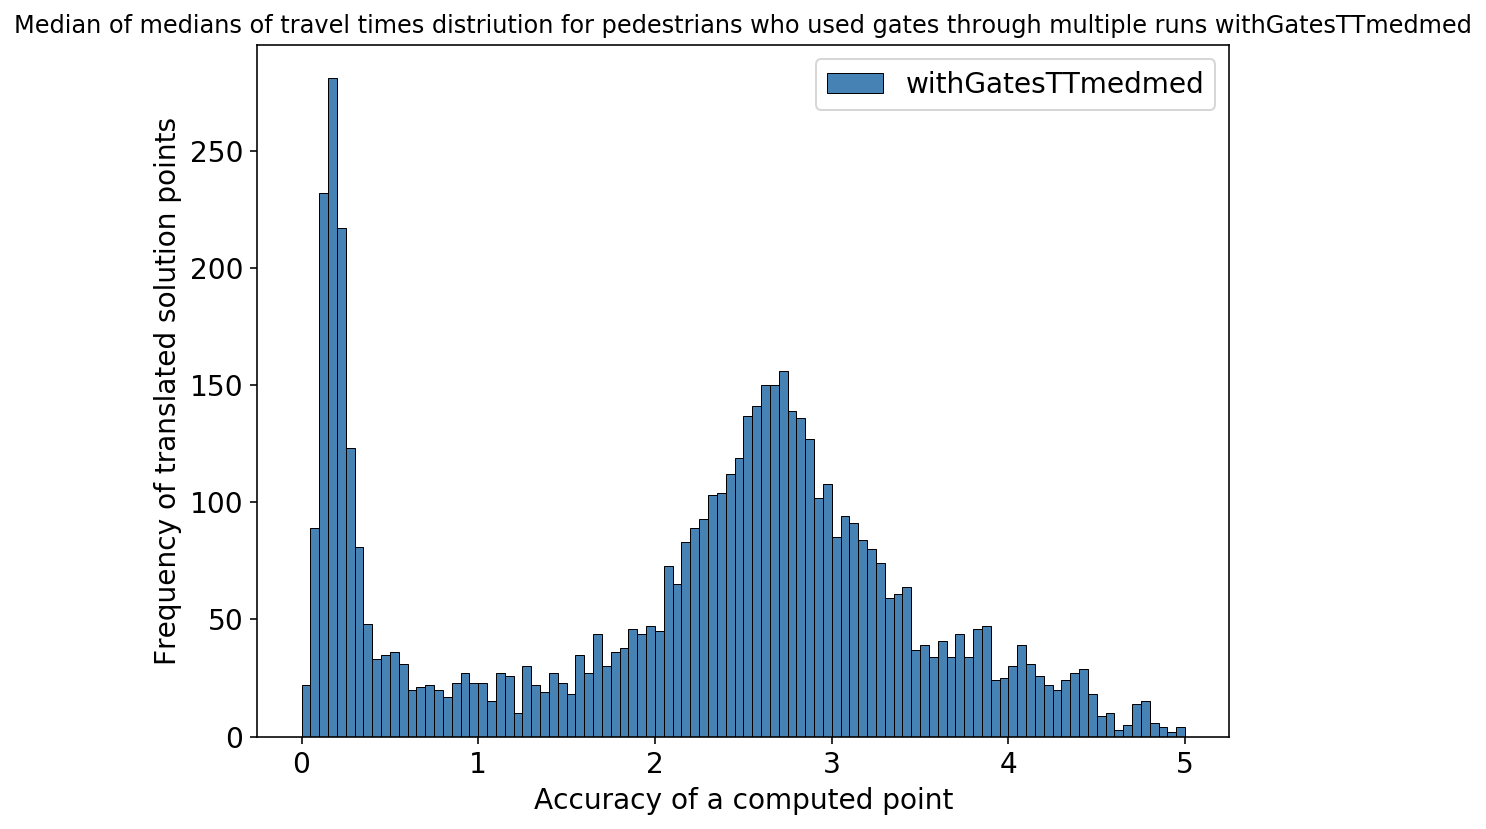

In [63]:
#SixPlots(all_data107)


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

data = dF
f, (ax2) = plt.subplots(1, 1, sharey=True, figsize=(10, 6))

data['withGatesTTmedmed'].plot.hist(bins=100, ax=ax2, color='steelblue', edgecolor='black', linewidth=0.5, range=[0,5]) 
f.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

ax2.tick_params(axis='x', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=14)
plt.legend(prop={'size': 14})
plt.xlabel('Accuracy of a computed point', fontsize=14)
plt.ylabel('Frequency of translated solution points', fontsize=14)


ax2.set_title('Median of medians of travel times distriution for pedestrians who used gates through multiple runs withGatesTTmedmed') 

plt.savefig('/Users/leobouraux/Desktop/foo1.png', format='png', dpi=333)

# DATA with fixed density threshold 2.07

In [278]:
import pandas as pd 
data = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-217/SO_gating_KPIs_MDaWZEnIO.csv') 
data = data.dropna()
data = data.sort_values(by=['allPedsTTmedmed'])[:100]
data.head()

allPedsTTmedmed  allPedsTTvarmed  allPedsSize  withGatesTTmedmed  \
1180        22.719093        11.829555      33934.0          22.535886   
807         22.734009        12.218364      34309.0          22.454699   
394         22.744032        12.291530      34152.0          22.389750   
302         22.753386        12.787906      34193.0          22.321043   
1010        22.837451        12.060419      34341.0          22.610983   

      withoutGatesTTmedmed  withGatesTTvarmed  withoutGatesTTvarmed  
1180             23.808971          10.880274             15.130888  
807              24.770062          11.137744             15.974696  
394              25.657257          10.492915             16.132324  
302              25.277224          11.665742             15.917370  
1010             24.901038          10.799959             16.046822

In [230]:
data.describe()

allPedsTTmedmed  allPedsTTvarmed   allPedsSize  withGatesTTmedmed  \
count      1434.000000      1434.000000   1434.000000        1434.000000   
mean         28.987831        21.164648  34385.577406          31.528848   
std           4.055883         8.485960    292.578896           5.604186   
min          22.719093        10.612019  33293.000000          22.275605   
25%          24.819591        13.553202  34199.250000          25.332859   
50%          29.555552        19.614544  34385.500000          32.911473   
75%          31.174397        25.764036  34581.000000          35.285512   
max          42.028942        46.306474  35377.000000          43.753103   

       withoutGatesTTmedmed  withGatesTTvarmed  withoutGatesTTvarmed  
count           1434.000000        1434.000000           1434.000000  
mean              23.220654          17.865514             24.428178  
std                1.528976           5.766650              9.891471  
min               21.347379           9.679297             12.160906  
25%               22.154070          12.293584             16.339885  
50%               22.524984          17.491635             21.434915  
75%               23.895714          21.434522             30.144848  
max               30.284891          33.738627             51.732095

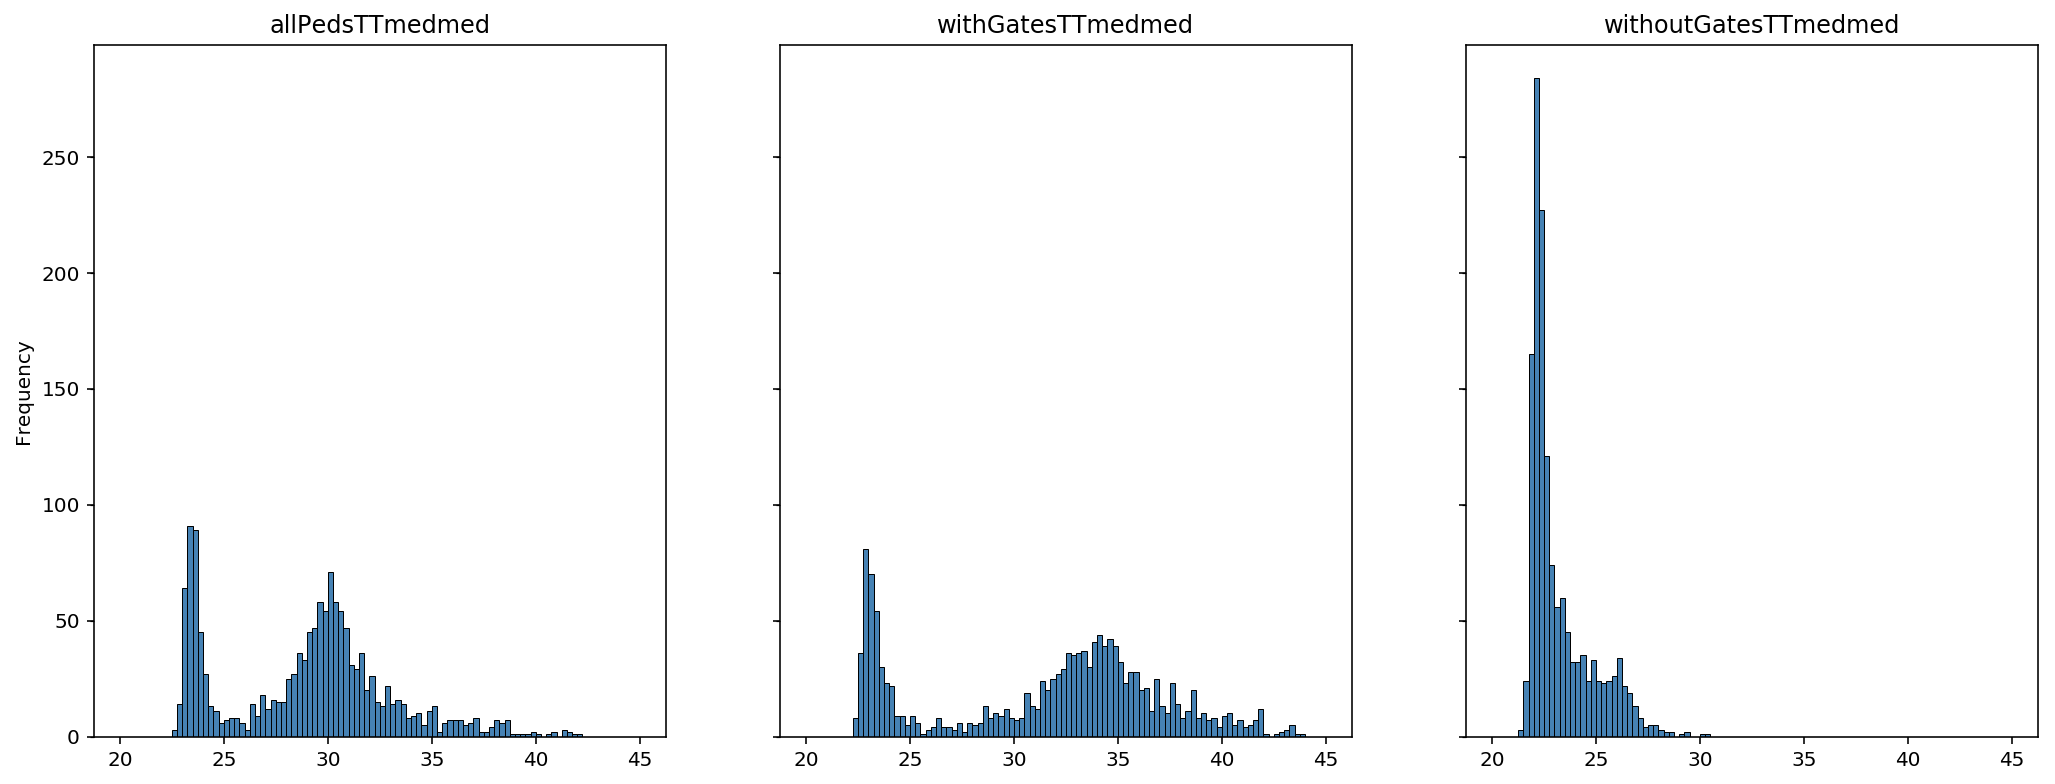

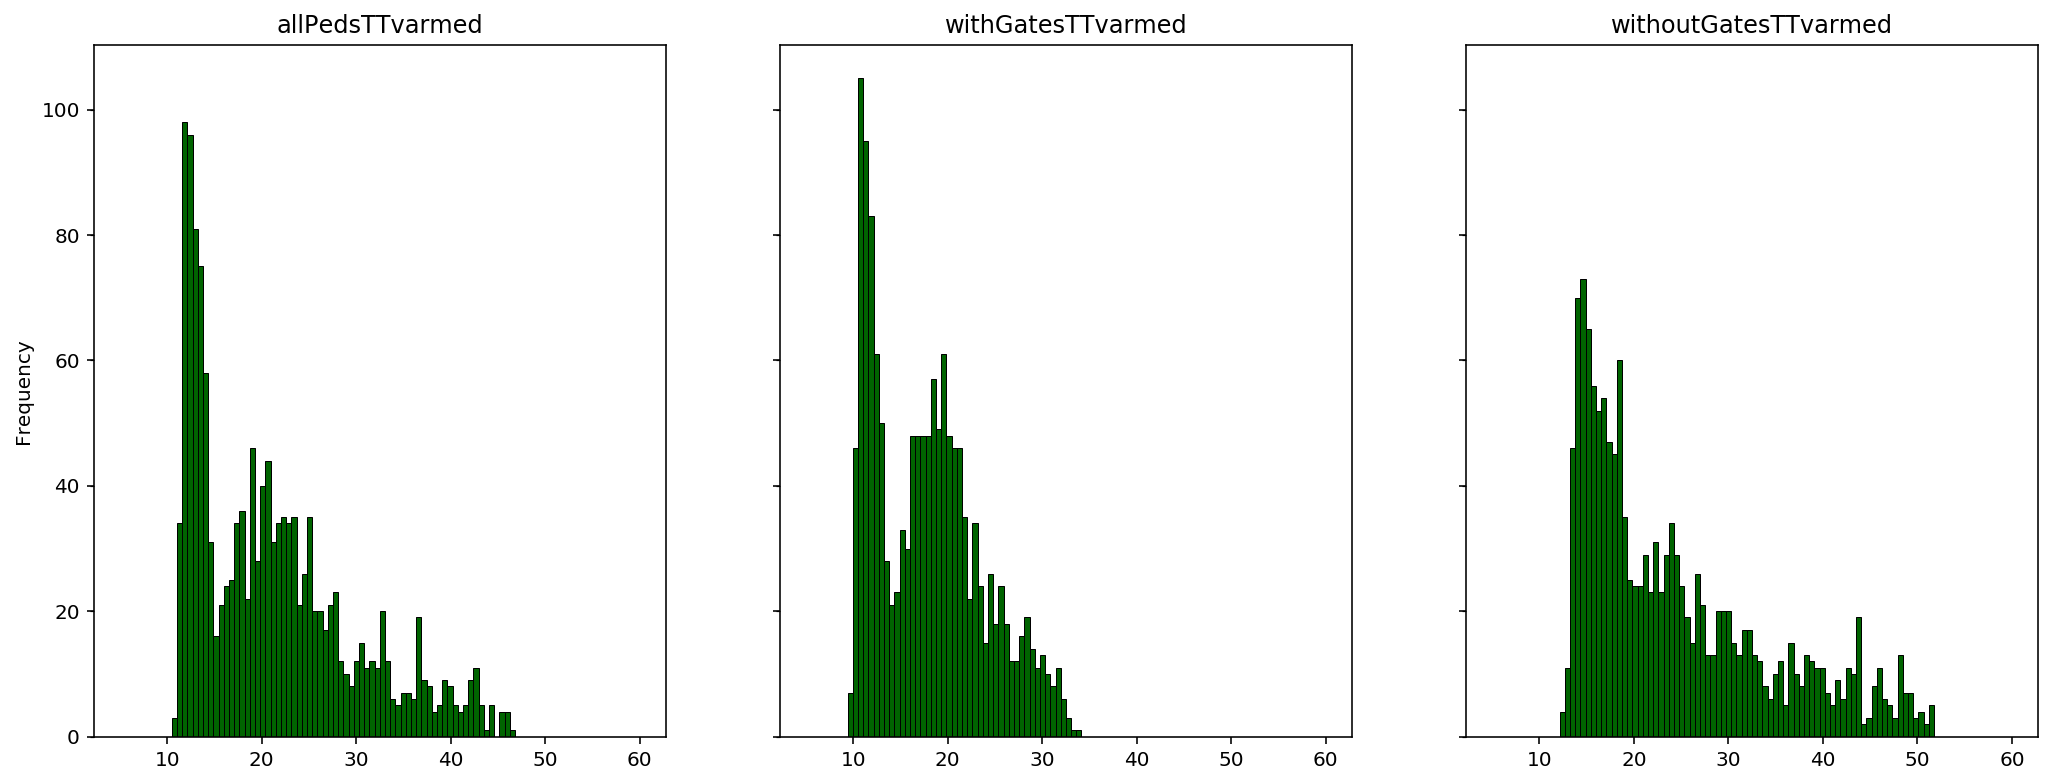

In [231]:
SixPlots(data)

----
### 4 different runs 

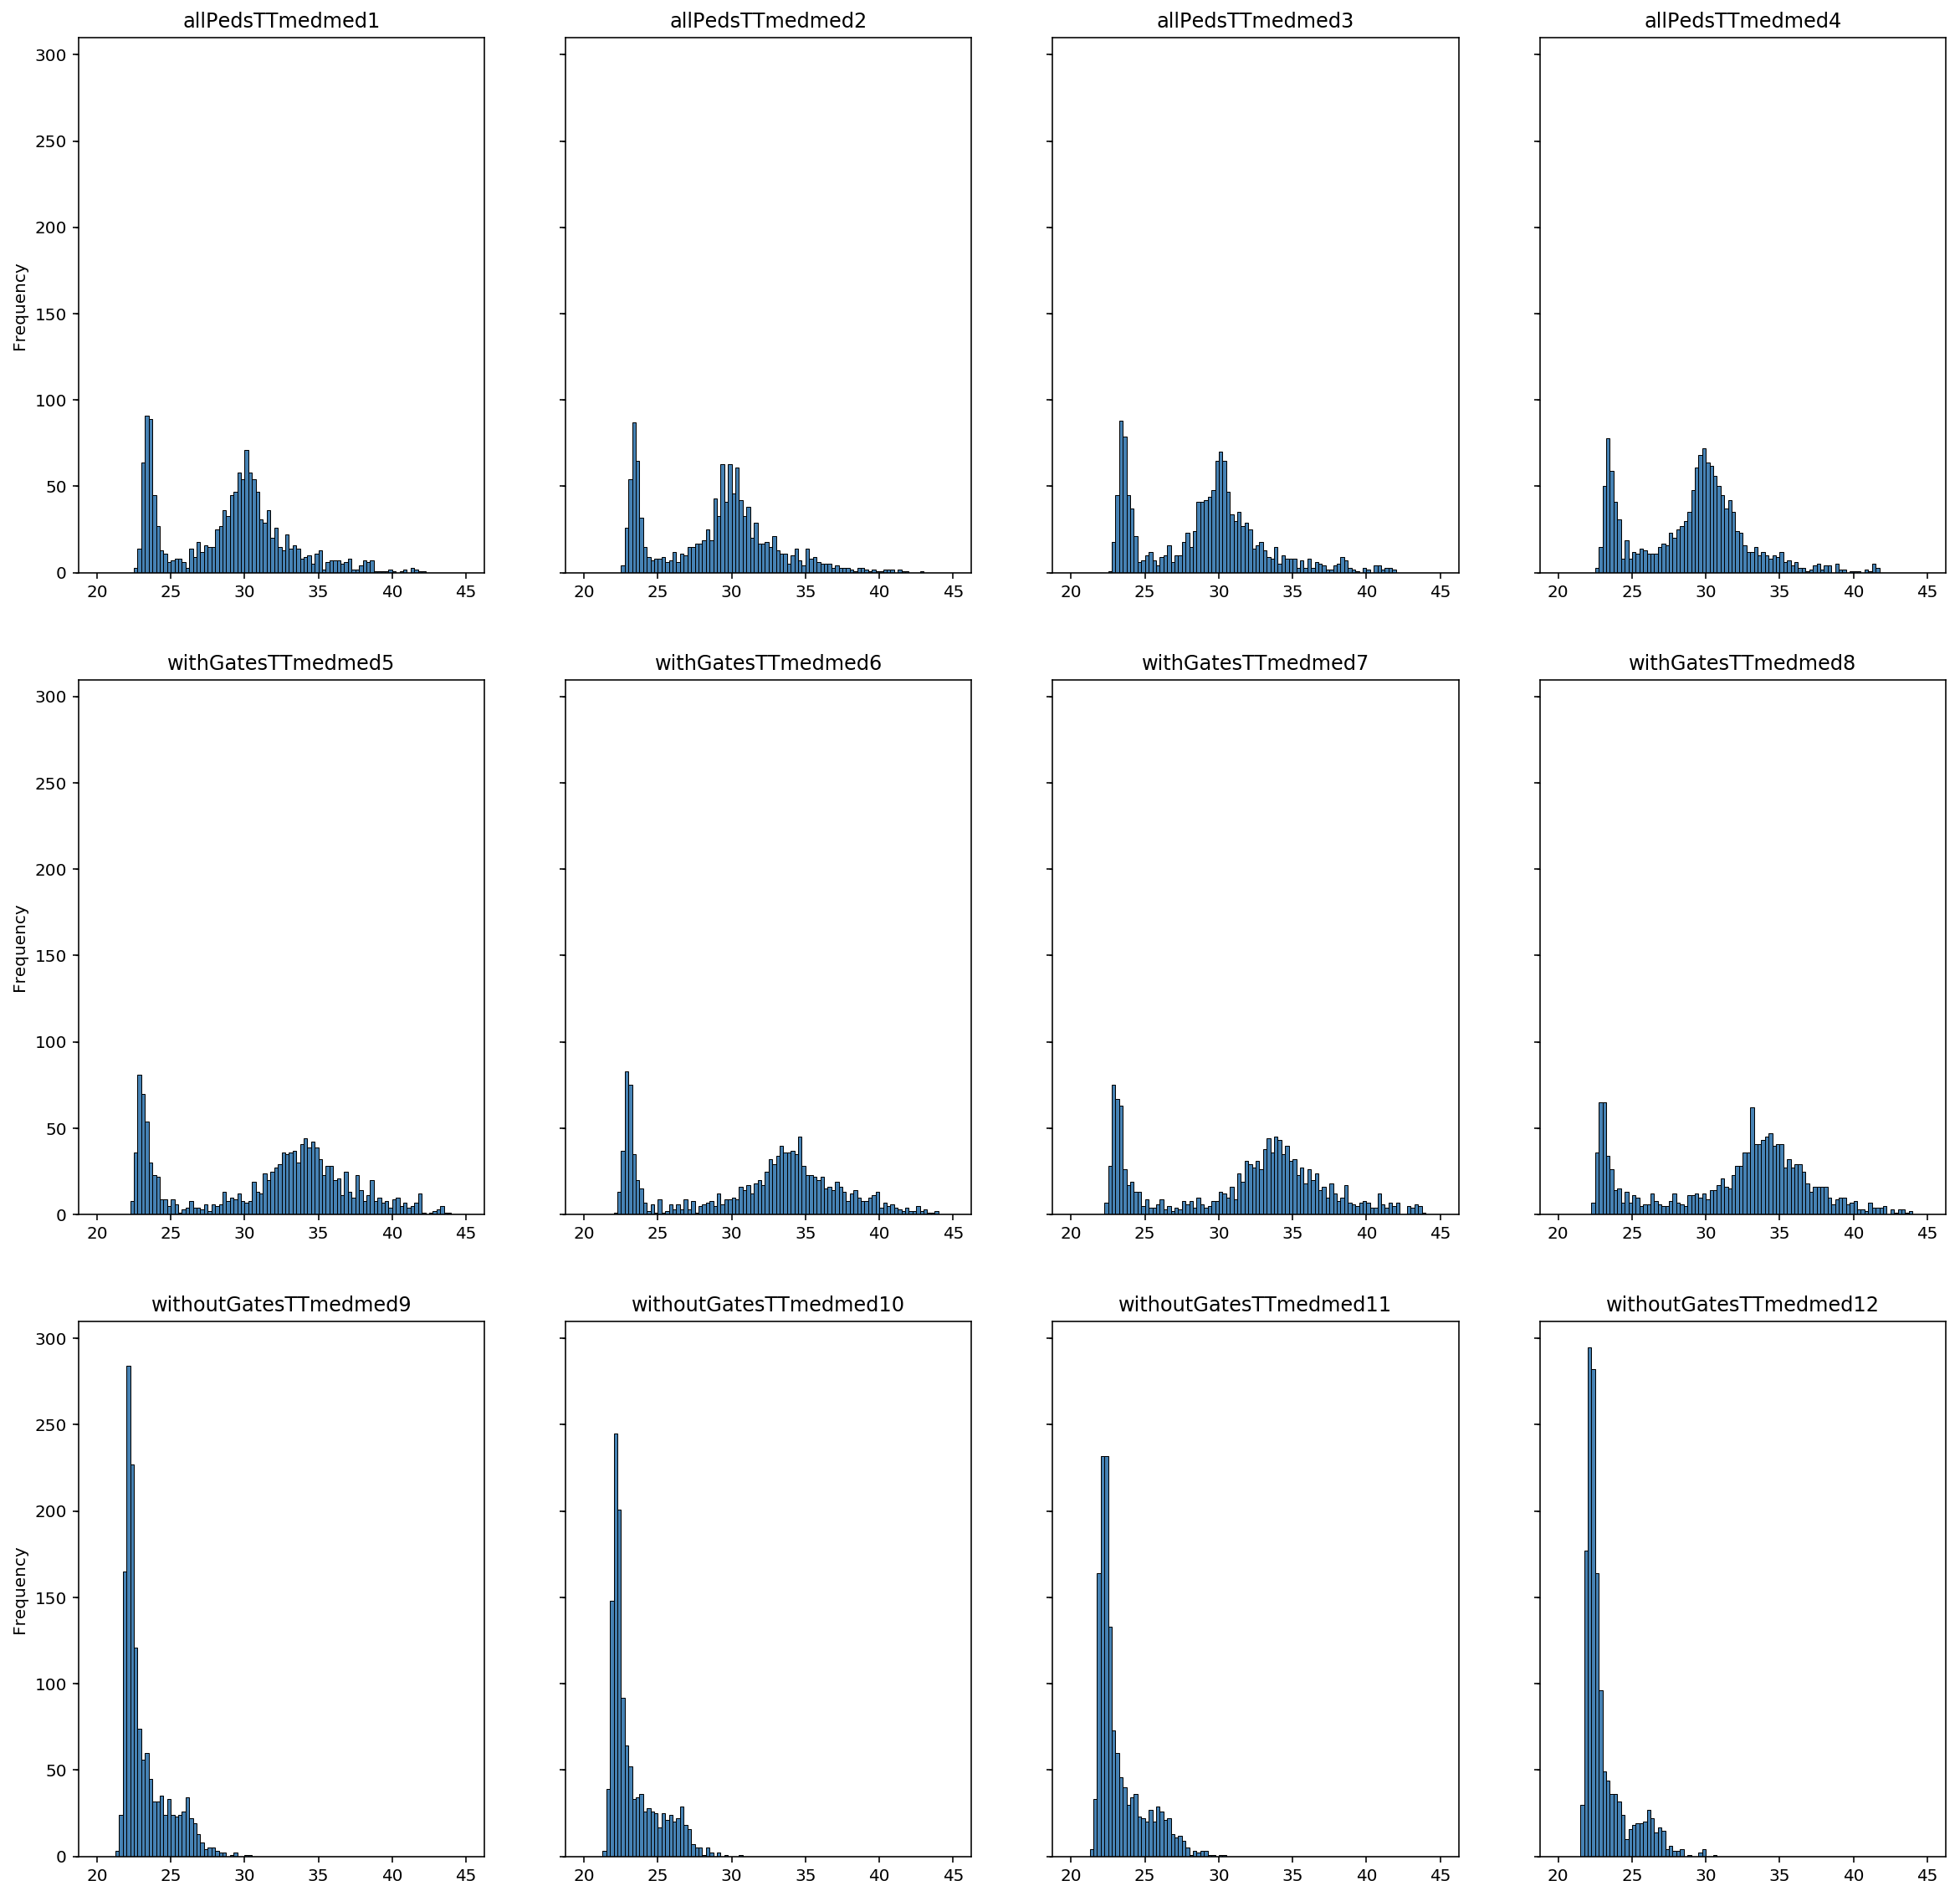

In [232]:
import pandas as pd 
data1 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-217/SO_gating_KPIs_MDaWZEnIO.csv') 
data1 = data1.dropna()
data2 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-217/SO_gating_KPIs_p0sPw3OYQ.csv') 
data2 = data2.dropna()
data3 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-217/SO_gating_KPIs_xDiJTm1yP.csv') 
data3 = data3.dropna()
data4 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/density-217/SO_gating_KPIs_zPAfwFZvH.csv') 
data4 = data4.dropna()
datas = [data1, data2, data3, data4]

FOURSIMU(datas, isMEDMED=True)

Chaque Run produit la même distribution de temps de trajets

### all datas

In [233]:
all_data217 = data1.append(data2).append(data3).append(data4)
all_data217.describe()

allPedsTTmedmed  allPedsTTvarmed   allPedsSize  withGatesTTmedmed  \
count      5590.000000      5590.000000   5590.000000        5590.000000   
mean         29.032406        21.193713  34381.306261          31.612798   
std           3.993400         8.381773    293.972535           5.518199   
min          22.628830        10.612019  33293.000000          22.227106   
25%          25.448186        13.690964  34188.000000          26.413325   
50%          29.553786        19.763033  34381.000000          33.046664   
75%          31.203144        25.708729  34578.000000          35.306198   
max          42.927352        46.980414  35451.000000          43.963344   

       withoutGatesTTmedmed  withGatesTTvarmed  withoutGatesTTvarmed  
count           5590.000000        5590.000000           5590.000000  
mean              23.212174          17.905638             24.435546  
std                1.574027           5.686905              9.779590  
min               21.347379           9.611160             12.151793  
25%               22.147577          12.442760             16.562465  
50%               22.503041          17.656999             21.496057  
75%               23.818585          21.423835             30.106237  
max               30.647296          33.738627             52.183458

In [6]:
SixPlots(all_data217)

NameError: name 'all_data217' is not defined

# DATA with density

In [235]:
import pandas as pd 
data = pd.read_csv('../../../../GraphsSimu/data_to_visualize/with-density/SO_gating_KPIs_Fo1tSl72E.csv') 
data = data.dropna()
data.head()

allPedsTTmedmed  allPedsTTvarmed  allPedsSize  withGatesTTmedmed  \
0        23.535719        14.134661      34240.0          23.156228   
1        23.351567        11.688047      34548.0          23.017078   
2        23.961716        14.765069      34448.0          23.350840   
3        23.299994        13.624302      34382.0          22.967308   
5        25.517758        12.548086      34585.0          26.728280   

   withoutGatesTTmedmed  withGatesTTvarmed  withoutGatesTTvarmed  
0             26.568775          11.867181             18.386389  
1             25.100986          10.537570             14.711393  
2             27.220010          13.291119             19.589346  
3             25.332605          12.059635             17.501064  
5             22.487452          11.478191             14.005293

In [236]:
data.describe()

allPedsTTmedmed  allPedsTTvarmed   allPedsSize  withGatesTTmedmed  \
count      1561.000000      1561.000000   1561.000000        1561.000000   
mean         25.352156        15.360436  34378.258168          26.003976   
std           3.495560         6.569770    288.781224           5.030757   
min          22.594487        10.648191  33314.000000          22.297388   
25%          23.370333        12.270139  34180.000000          23.006100   
50%          23.743347        13.024871  34372.000000          23.467459   
75%          25.499247        14.108548  34578.000000          26.601212   
max          41.450646        45.015594  35387.000000          45.165888   

       withoutGatesTTmedmed  withGatesTTvarmed  withoutGatesTTvarmed  
count           1561.000000        1561.000000           1561.000000  
mean              24.463673          13.377030             18.789480  
std                1.636069           4.624521              7.350206  
min               21.477938           9.470740             11.755046  
25%               22.965295          11.050150             15.012016  
50%               24.565727          11.646970             16.560993  
75%               25.812650          12.821269             18.289448  
max               29.323988          32.753188             50.446513

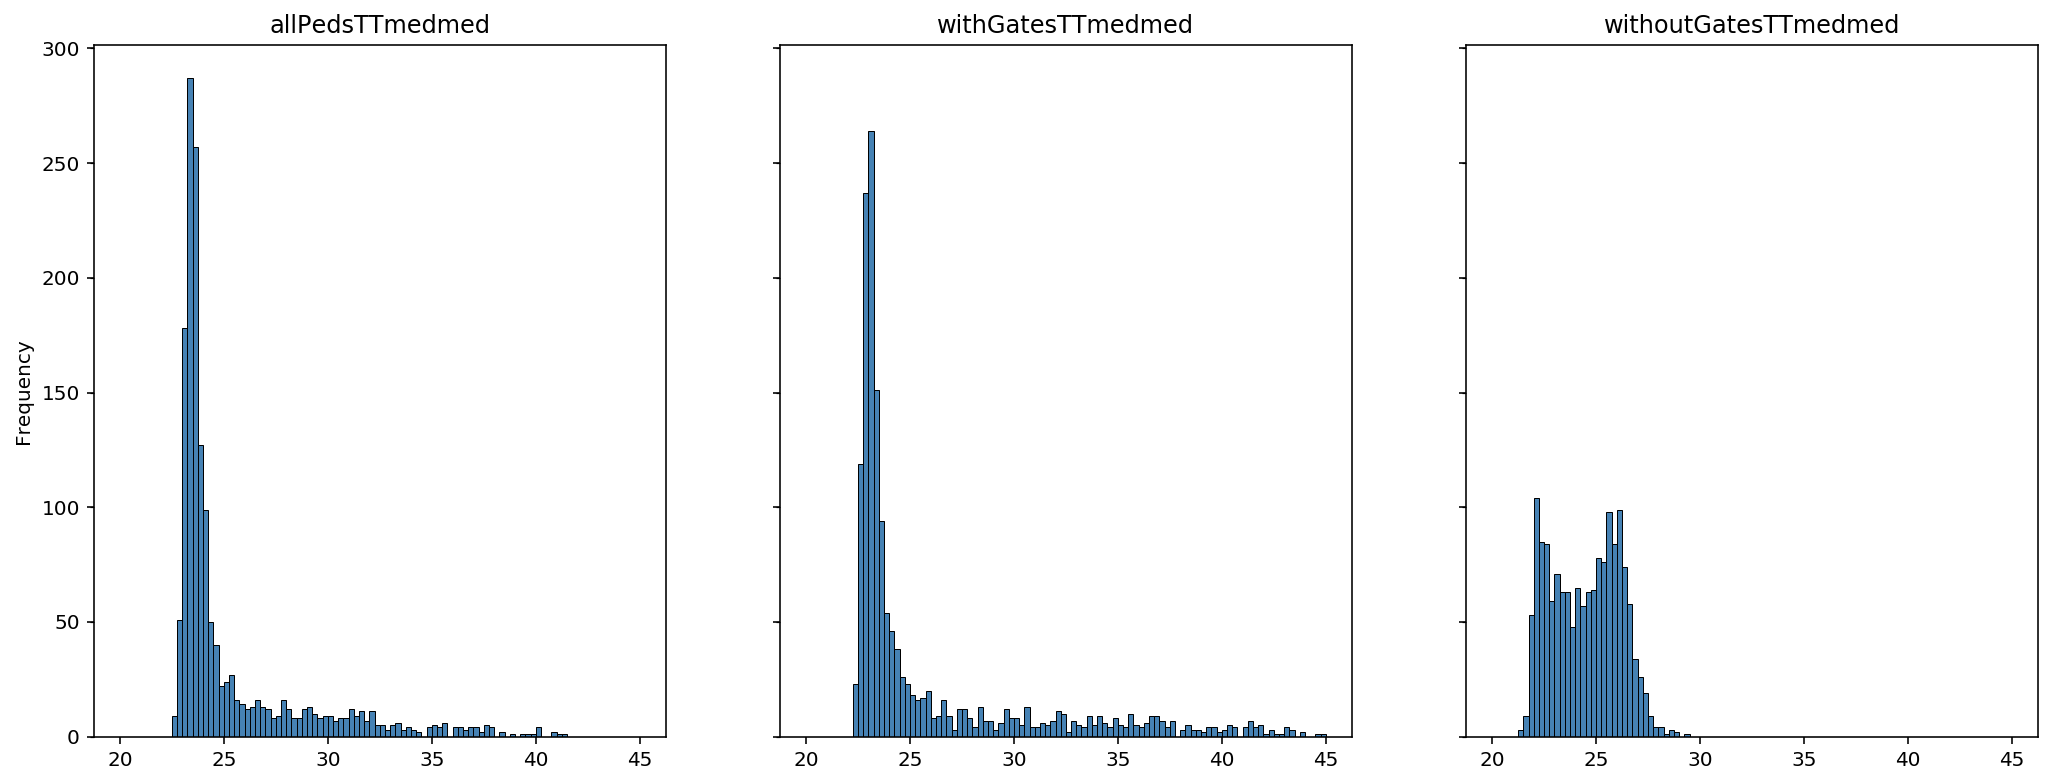

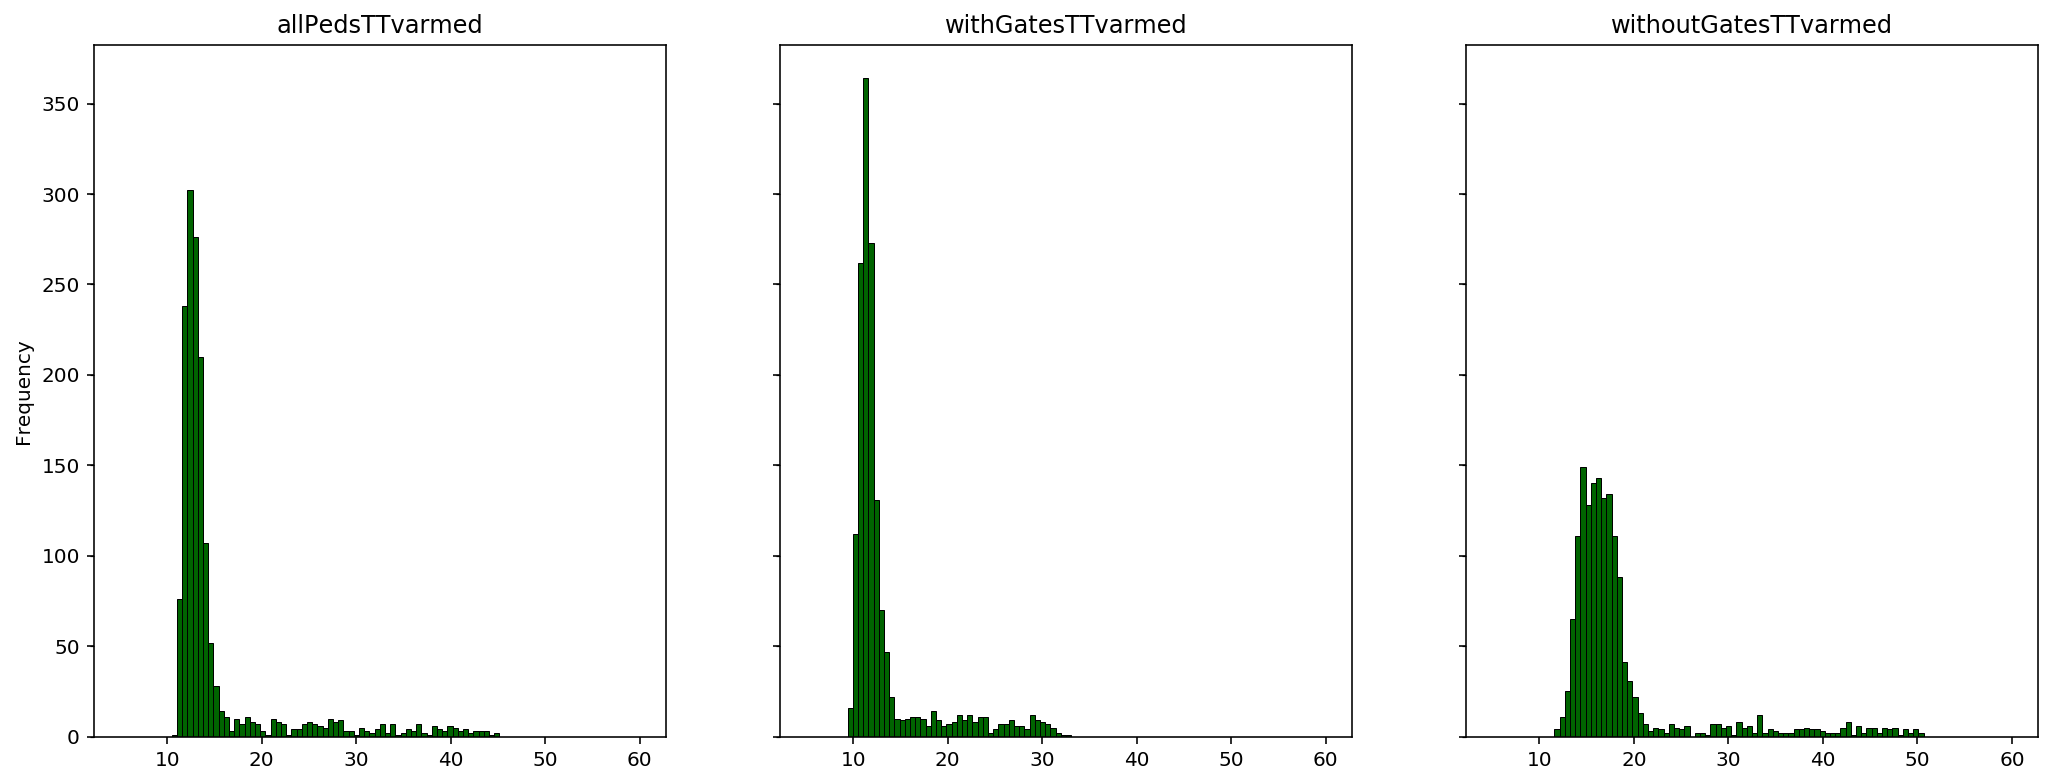

In [237]:
SixPlots(data)

----
### 4 different runs 

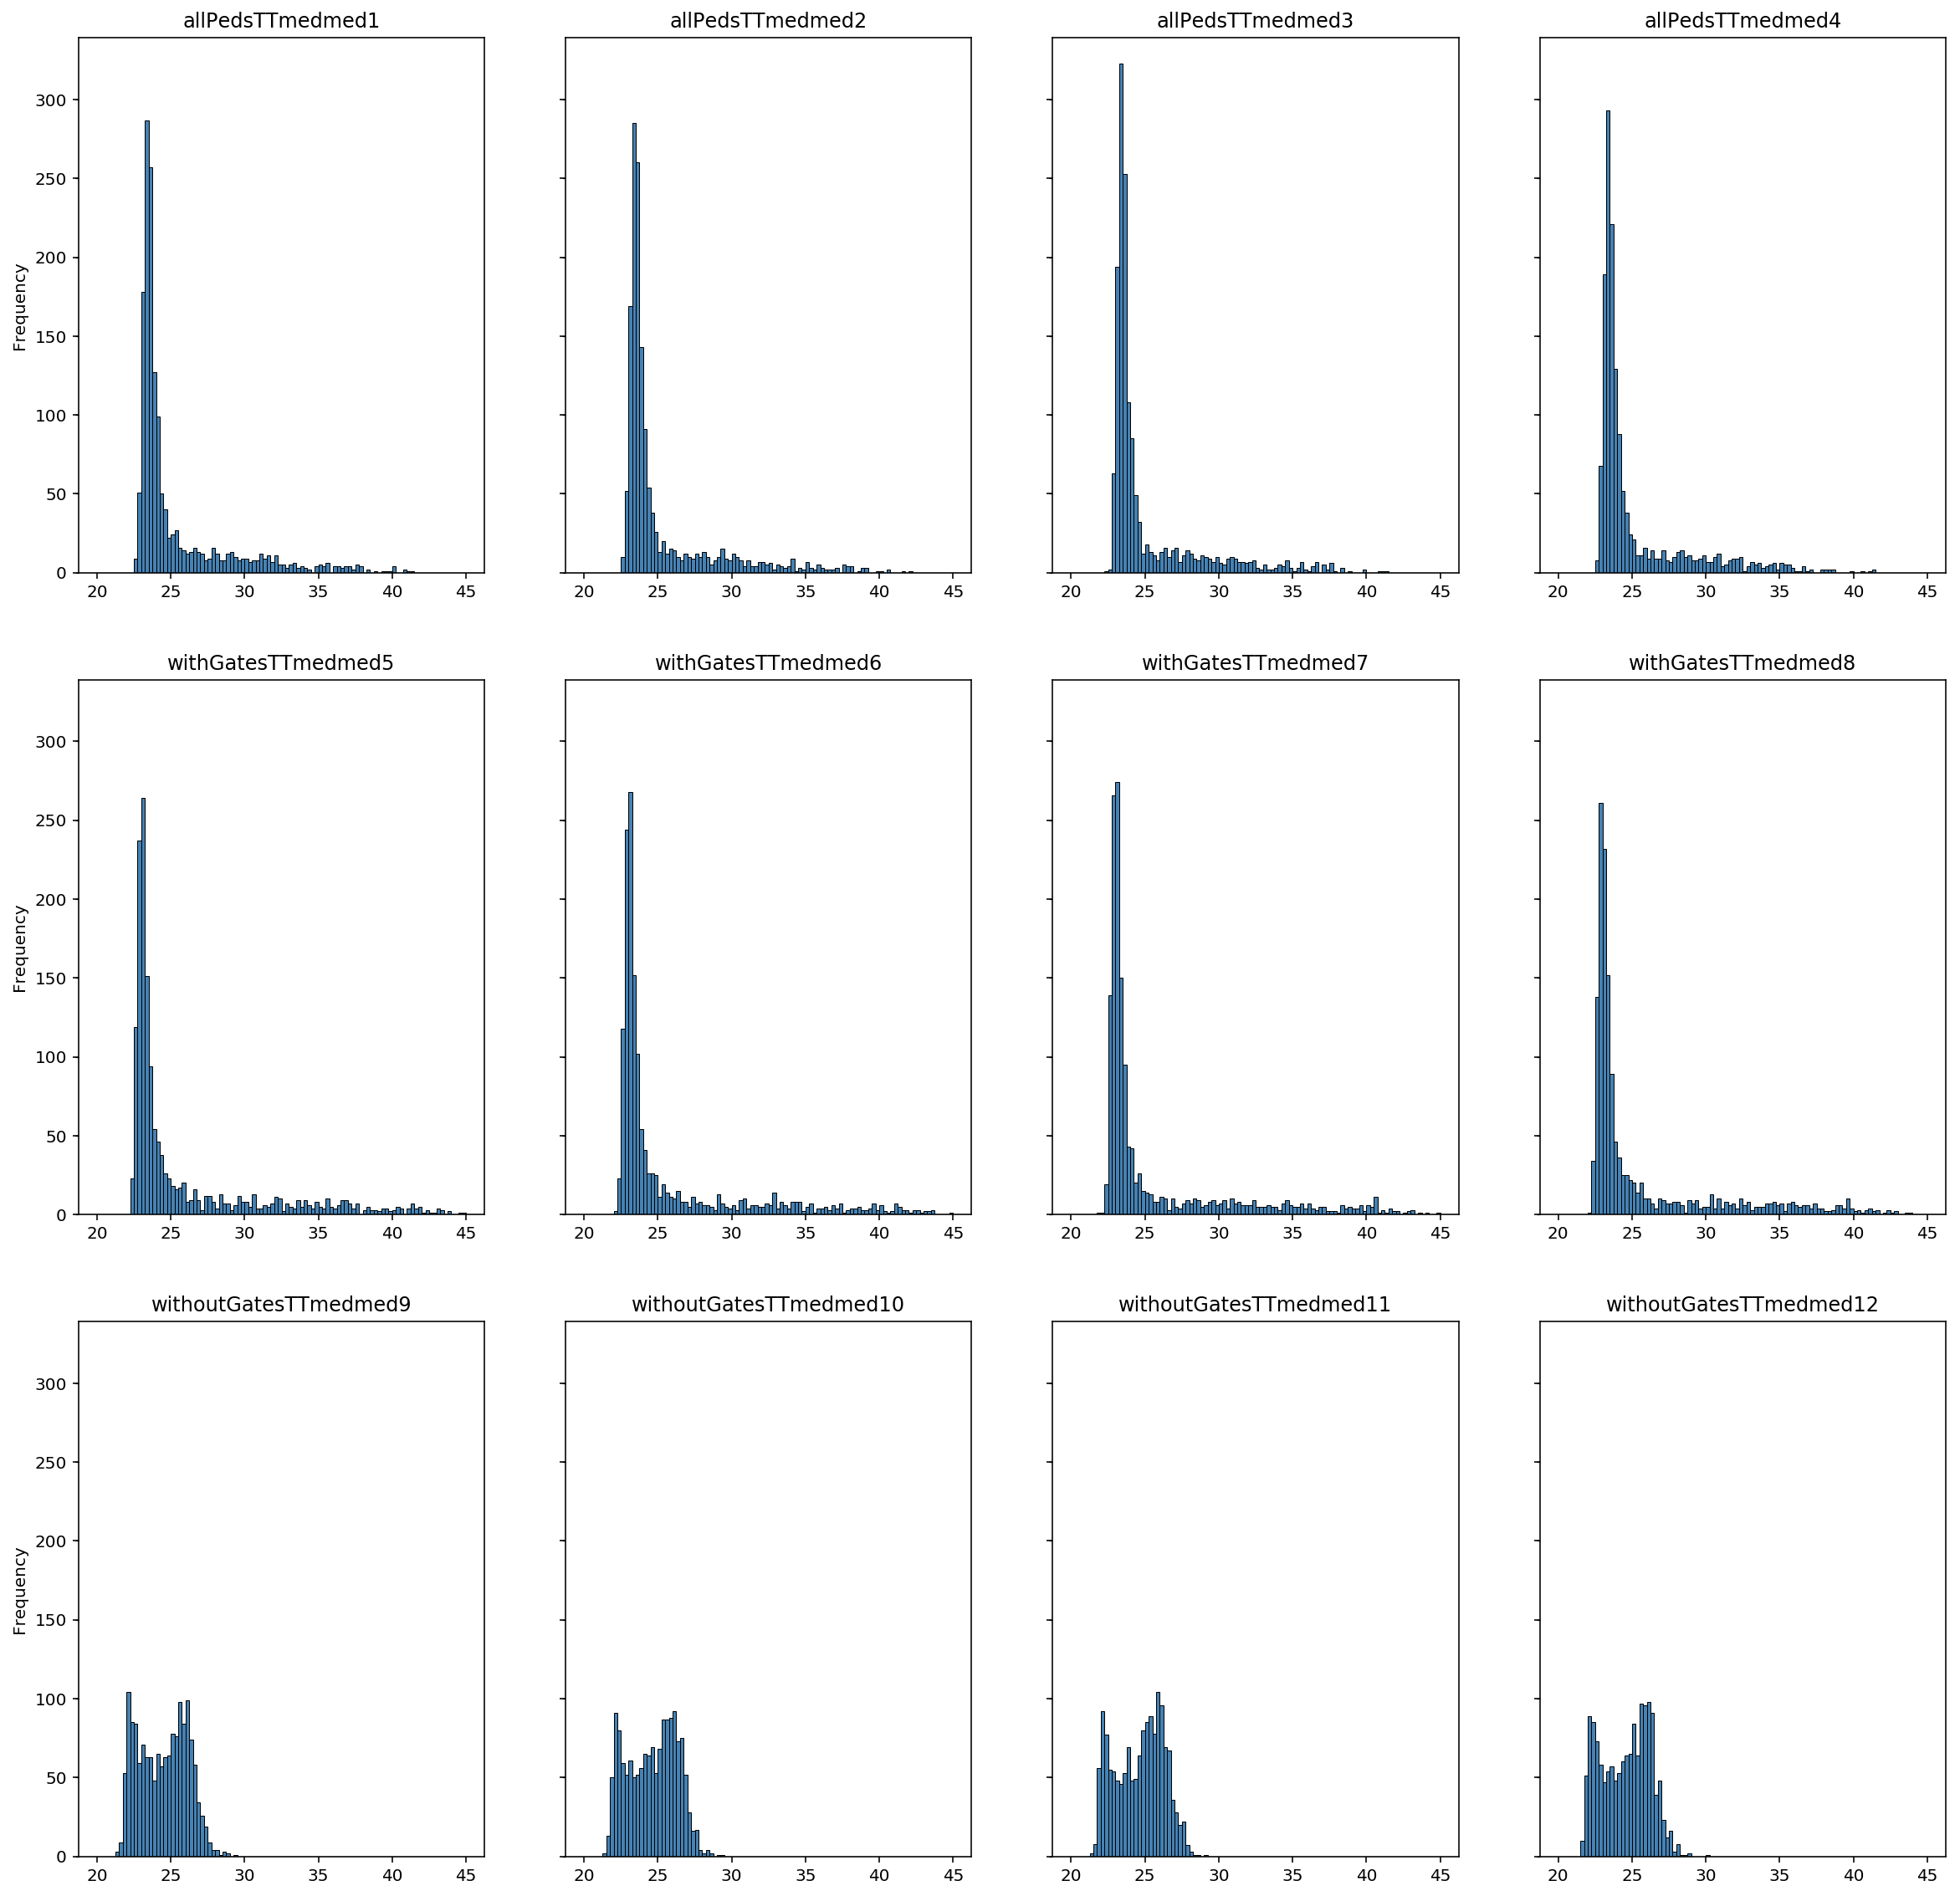

In [238]:
import pandas as pd 
data1 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/with-density/SO_gating_KPIs_Fo1tSl72E.csv') 
data1 = data1.dropna()
data2 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/with-density/SO_gating_KPIs_irgySkwQ2.csv') 
data2 = data2.dropna()
data3 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/with-density/SO_gating_KPIs_jHiGyH8pD.csv') 
data3 = data3.dropna()
data4 = pd.read_csv('../../../../GraphsSimu/data_to_visualize/with-density/SO_gating_KPIs_tp0OXT8cV.csv') 
data4 = data4.dropna()
datas = [data1, data2, data3, data4]

FOURSIMU(datas, isMEDMED=True)

Chaque Run produit la même distribution de temps de trajets

### all datas

In [239]:
all_data_with = data1.append(data2).append(data3).append(data4)
all_data_with.describe()

allPedsTTmedmed  allPedsTTvarmed   allPedsSize  withGatesTTmedmed  \
count      6081.000000      6081.000000   6081.000000        6081.000000   
mean         25.249485        15.288826  34379.562407          25.837176   
std           3.414258         6.395086    294.310290           4.931108   
min          22.444155        10.648191  33132.000000          21.954424   
25%          23.357790        12.318397  34186.000000          22.977409   
50%          23.706585        13.039480  34385.000000          23.387748   
75%          25.259243        14.144797  34576.000000          26.121902   
max          42.206878        46.692015  35419.000000          45.165888   

       withoutGatesTTmedmed  withGatesTTvarmed  withoutGatesTTvarmed  
count           6081.000000        6081.000000           6081.000000  
mean              24.560252          13.328815             18.782065  
std                1.642006           4.508049              7.151901  
min               21.426894           9.214066             11.491876  
25%               23.083649          11.064272             15.150042  
50%               24.731059          11.693537             16.737067  
75%               25.911524          12.731081             18.414840  
max               30.014741          32.835904             51.519307

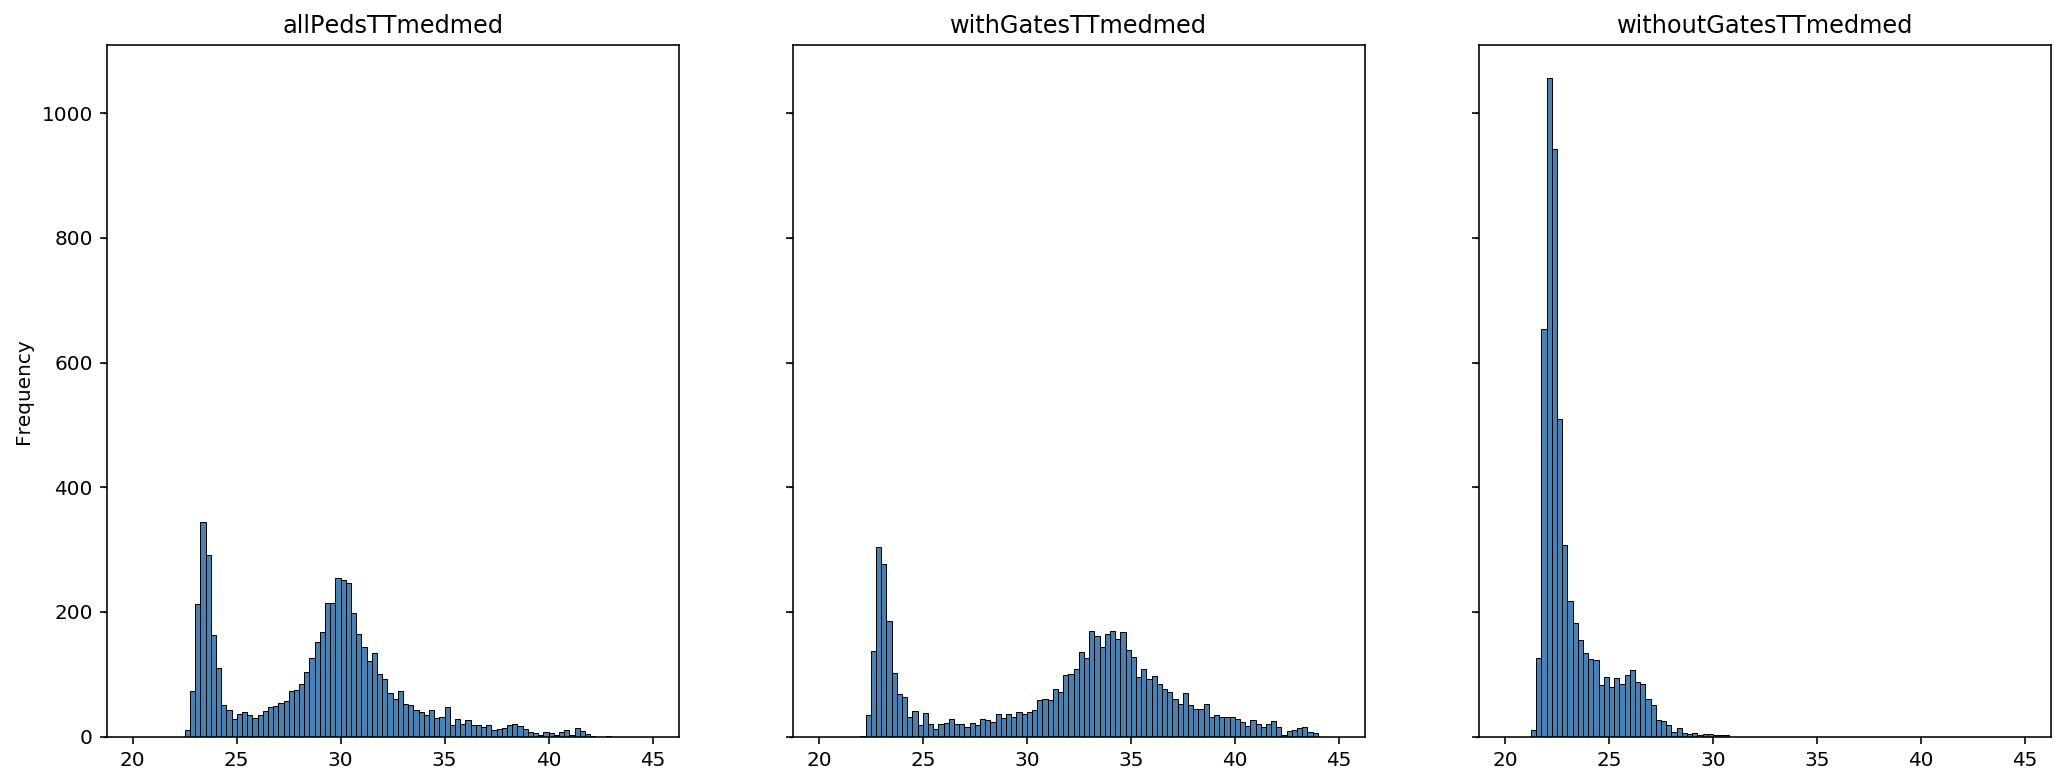

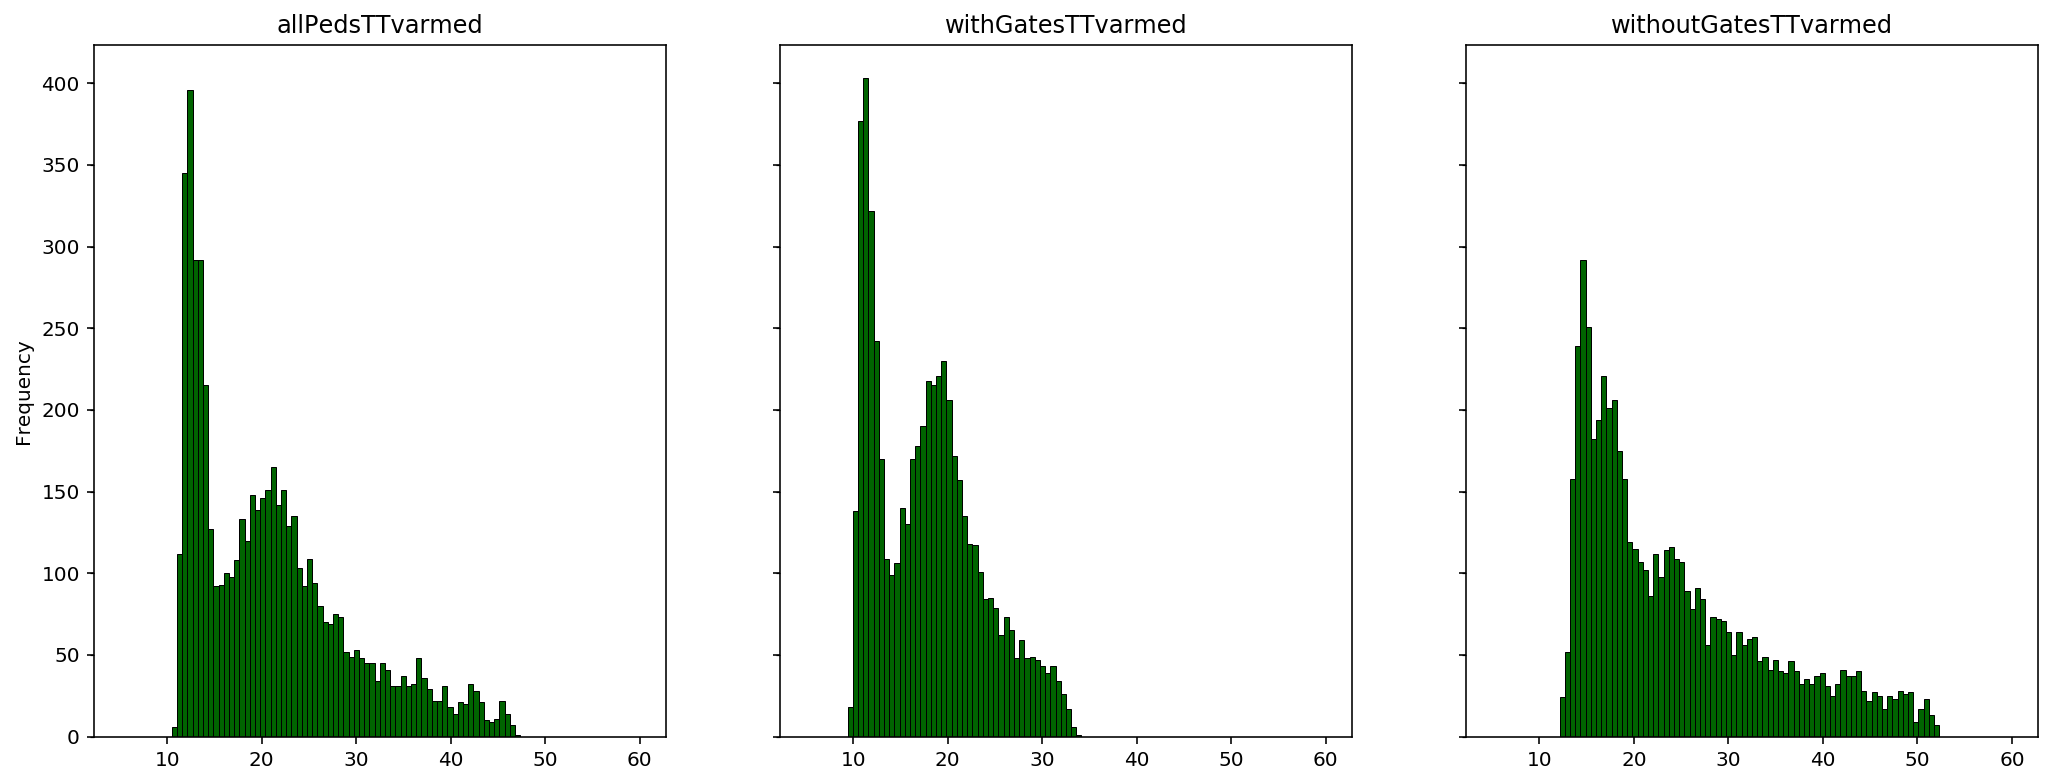

In [240]:
SixPlots(all_data)

# COMPARAISON DES 3 DIFFERENTS SCENARIOS

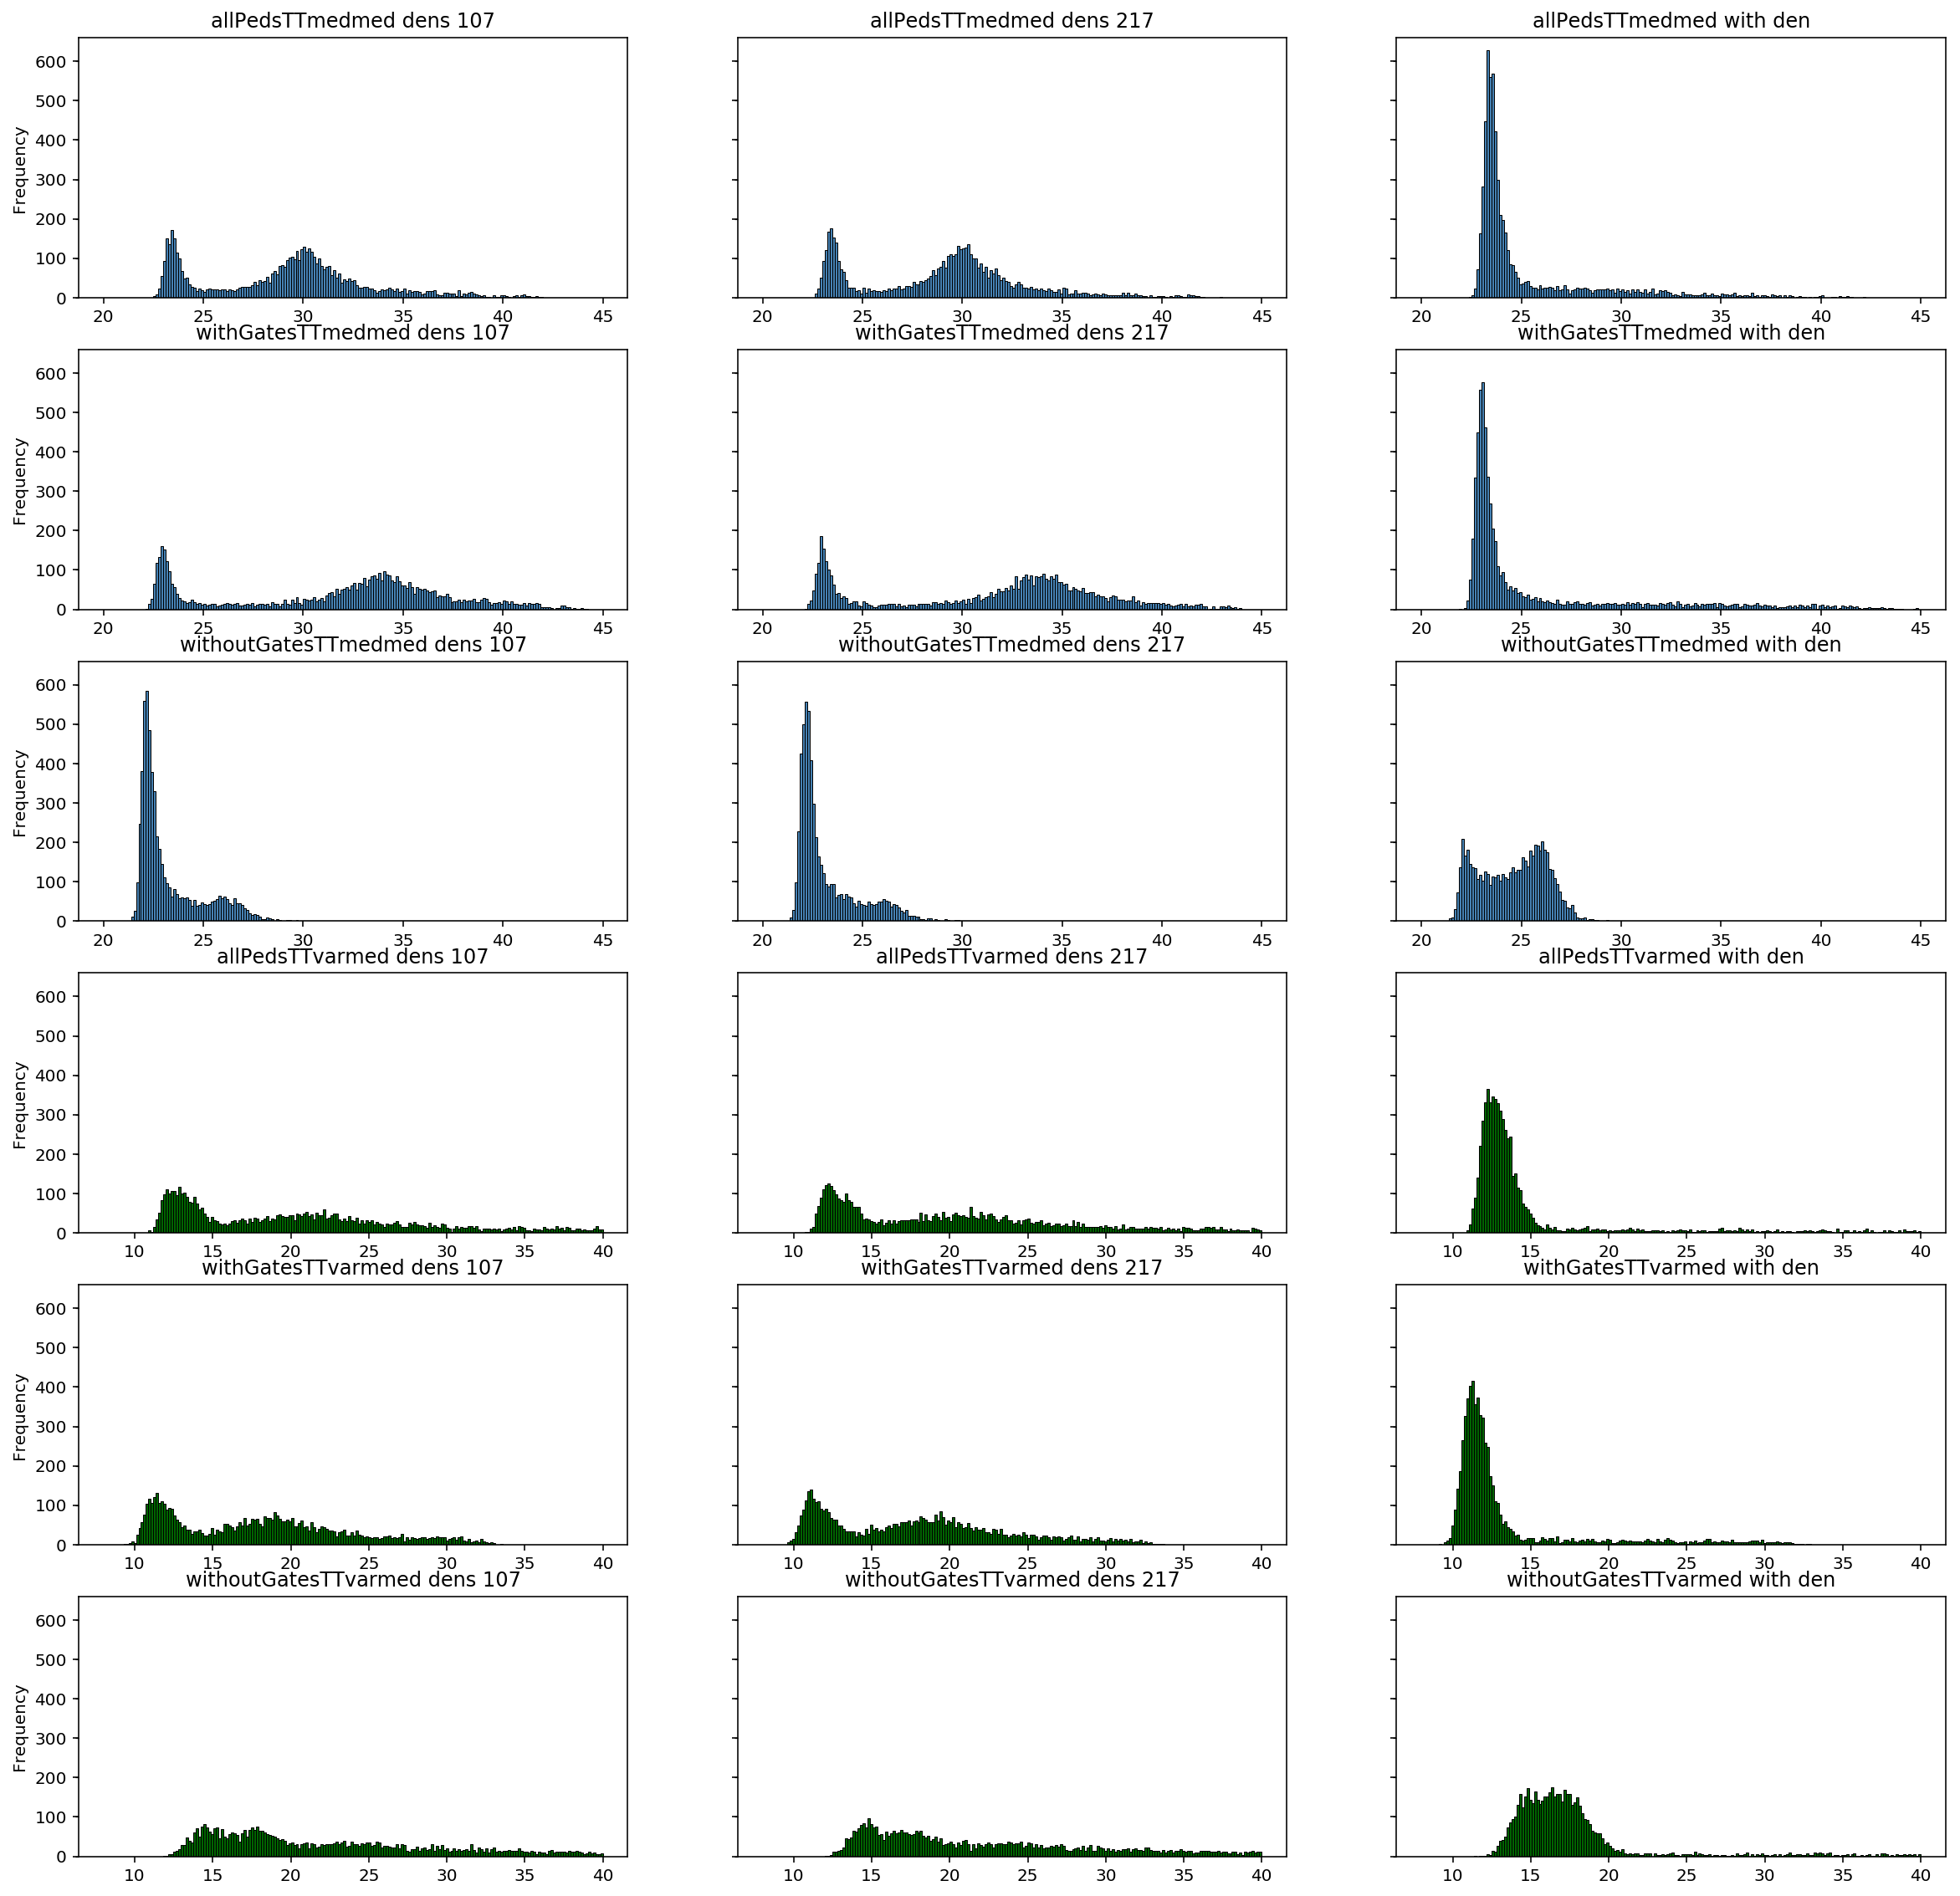

In [245]:
all_datas = [all_data107, all_data217, all_data_with]

THREE_DIF_PARAM(all_datas)

No handles with labels found to put in legend.


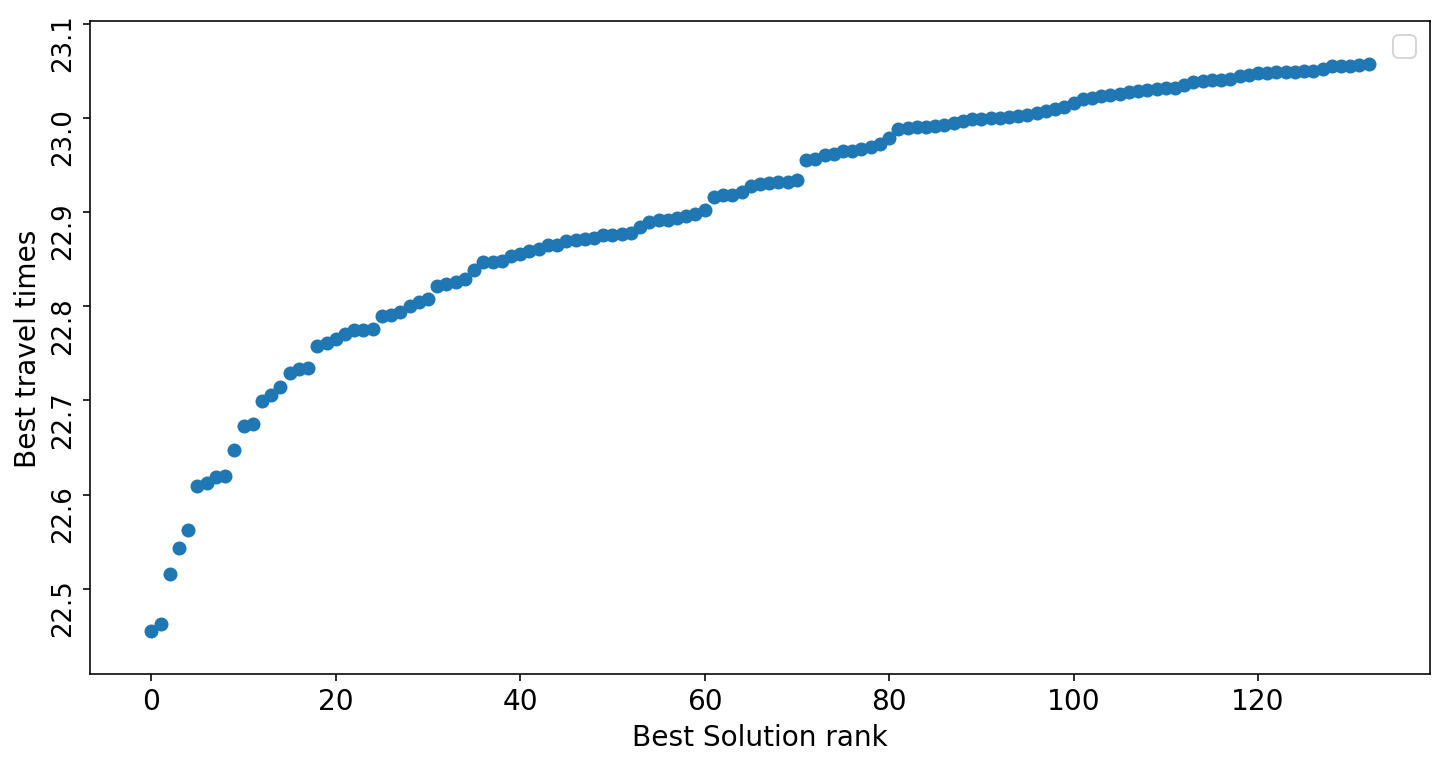

In [407]:
data = pd.read_csv('../../../../GraphsSimu/data_to_visualize/adaptive/SO_gating_KPIs_jVrCpFd46.csv') 
#print(datawith_1)
data = data.dropna().sort_values(by=['allPedsTTmedmed'])[:133]


x = np.arange(133)
y3 = data['allPedsTTmedmed'].tolist()

plt.scatter(x,y3)


fig = plt.gcf()
fig.set_size_inches(12,6)
ax2 = plt.gca()
ax2.tick_params(axis='x', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=13)
plt.yticks(rotation=90)
plt.xlabel('Best Solution rank', size=14)
plt.ylabel('Best travel times', size=14)
plt.legend(prop={'size': 14})
plt.savefig('/Users/leobouraux/Desktop/foo1.png', format='png', dpi=333)
plt.show()

ValueError: x and y must be the same size

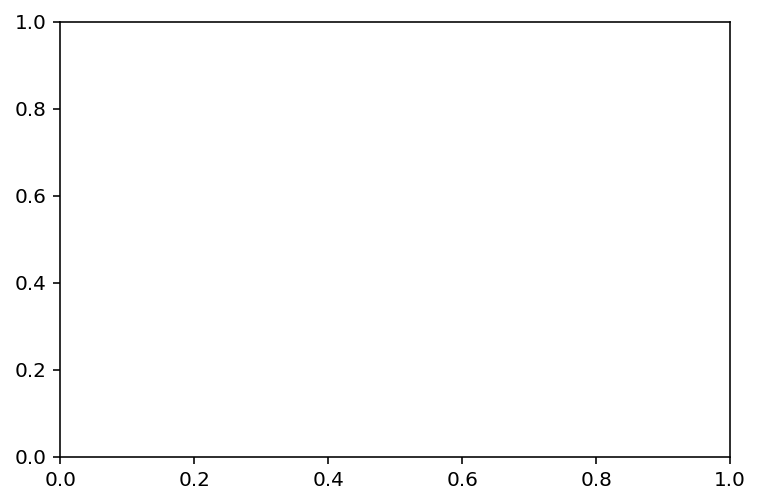

In [406]:


x = np.arange(133)
#x2 = np.arange(150)

#y1 = data107_s0['allPedsTTmedmed'].tolist()
#y2 = data107_s1['allPedsTTmedmed'].tolist()
#y3 = data107_s2['allPedsTTmedmed'].tolist()

#y1a = data107_s['withGatesTTmedmed'].tolist()
#y2 = data207_s['allPedsTTmedmed'].tolist()
#y2a = data207_s['withGatesTTmedmed'].tolist()
y3 = datawith_s['allPedsTTmedmed'].tolist()
#y2a = data207_s['withGatesTTmedmed'].tolist()

#datas.plot(kind='scatter',x='allPedsTTmedmed',y=y,color='red')
#plt.plot(x,y1, label='threshold: 2.17')
#plt.plot(x,y2, label='threshold: 1.07')
#plt.plot(x,y3, label='treshold: 1.07')

#plt.plot(x,y1a)
#plt.plot(x, y2, label='treshold: 2.17')
#plt.plot(x,y2a)

import matplotlib.colors as colors

def truncate_colormap(cmap_str, minval=0.0, maxval=1.0, n=100):
    cmap = plt.get_cmap(cmap_str)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cm = plt.cm.get_cmap(truncate_colormap('Greys', 0.1, 1))
col = [5.17849627494648, 3.50861766539567, 4.4053761174892605, 3.82443491212695, 3.718150462813645,
 5.486999903465964, 4.455722044766594, 4.359500683092068, 4.252167558125502, 3.860152925732901,
 4.63231243271322, 3.2936745712945887, 5.143912923879873, 1.7165654870788638, 5.256530373620075,
 4.0604890362886366, 5.121066891299597, 5.231567083615999, 5.840247662960642, 5.249735578507179,
 4.3056392568815935, 5.090460656772546, 4.2588576340275885, 4.507304921188544, 3.43084736952804,
 4.27530288936454, 3.36433609128723, 4.3361407338583895, 3.6425645128377546, 3.496904122721773,
 3.602422645144685, 3.4873291747446302, 4.212285033402729, 4.16844919083901, 4.61749025592899,
 5.028412003547347, 4.904492697681372, 4.946163597251752, 4.178584214559708, 3.6882049106780443,
 3.0031542902256314, 5.536329179387213, 5.081444994163142, 4.999914546683658, 3.8631921426101594,
 3.7070891259730923, 4.766495613390799, 4.48061081079684, 5.294934802973199, 5.238114102733505]

sc = plt.scatter(x, y3, label='threshold optimized', s=40, c=col, cmap=cm)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Threshold value', labelpad=-40, rotation=0, y=1.05, fontsize=14)


#######################
fig = plt.gcf()
fig.set_size_inches(12,6)
ax2 = plt.gca()
ax2.tick_params(axis='x', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=13)
plt.yticks(rotation=90)
plt.xlabel('Best Solution rank', size=14)
plt.ylabel('Best travel times', size=14)
plt.legend(prop={'size': 14})
plt.savefig('/Users/leobouraux/Desktop/foo1.png', format='png', dpi=333)
plt.show()

#######################

print(y3)